# Module 1: Cấu hình Hệ thống & Mô hình Kênh Trường Gần (Physics Engine)


## 1. Tham số Hệ thống (`class Config`)

Chúng ta thiết lập các thông số dựa trên **Section II (System Model)** của bài báo:

| Biến số Python | Giá trị | Ý nghĩa & Liên hệ Bài báo |
| :--- | :--- | :--- |
| `N` | 64 | **Số lượng Ăng-ten (ELAA):** Số lượng phần tử lớn đặc trưng của 6G để tăng độ lợi mảng. |
| `N_RF` | 4 | **Số chuỗi RF:** Mô hình Hybrid Beamforming, giúp tiết kiệm năng lượng so với Fully-Digital ($N_{RF} \ll N$). |
| `M` | 16 | **Số sóng mang con (Subcarriers):** Chia băng thông lớn thành các phần nhỏ (OFDM). $M > 1$ tạo ra bài toán *Wideband*. |
| `fc` | 100 GHz | **Tần số trung tâm:** Băng tần Terahertz (THz). Tần số cao $\rightarrow$ Bước sóng $\lambda$ nhỏ $\rightarrow$ Vùng trường gần mở rộng. |
| `B` | 10 GHz | **Băng thông:** Rất lớn. Đây là nguyên nhân gây ra *Hiệu ứng băng rộng không gian* (Tán sắc tín hiệu). |
| `t_max` | 2.5 ns |**Độ trễ tối đa:** Giới hạn vật lý của linh kiện TTD (True-Time Delay) . |

---

## 2. Giải thích Thuật toán Tạo Kênh (`generate_channels`)

Hàm này tái hiện 2 đặc tính vật lý quan trọng nhất của bài toán:

### A. Tần số Sóng mang con (Wideband Effect)
Trong hệ thống băng rộng, tần số không cố định mà thay đổi theo chỉ số $m$.
Code hiện thực hóa công thức:
$$f_{m} = f_{c} + \frac{B}{M} \left(m - \frac{M-1}{2}\right)$$
*(Tương ứng với mô tả tần số tại Section II)*.
> **Tại sao quan trọng?** Vì tần số $f_m$ thay đổi, nên pha của tín hiệu cũng thay đổi theo, gây ra hiện tượng lệch chùm tia (Beam Squint) nếu không xử lý.  Kênh truyền được tính riêng cho từng tần số $f_m$ trong vòng lặp `for m in range(cfg.M)`. Điều này mô phỏng việc pha của tín hiệu thay đổi theo tần số.


### B. Khoảng cách Phi tuyến (Spherical Wavefront)
Đây là cốt lõi của **Trường gần (Near-field)**. Khoảng cách từ phần tử ăng-ten thứ $n$ đến người dùng $k$ được tính bằng Định lý Cosin:

$$r_{n,k} = \sqrt{r_k^2 + \delta_n^2 d^2 - 2 r_k \delta_n d \cos(\theta_k)}$$

* `r_k`: Khoảng cách từ tâm mảng đến người dùng.
* `delta_n`: Vị trí tương đối của ăng-ten con.
* `theta_k`: Góc của người dùng.

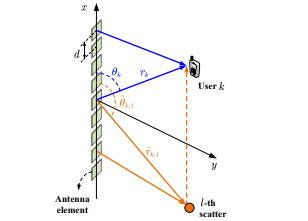
> **Liên hệ Bài báo:** Đây chính là **Công thức (6)**.
> $$r_{n}(r,\theta)=\sqrt{r^{2}+\chi_{n}^{2}d^{2}-2r\chi_{n}d\cos\theta}$$
> Lưu ý dấu căn bậc hai ($\sqrt{...}$). Trong trường xa (Far-field), người ta bỏ căn này để xấp xỉ tuyến tính. Nhưng ở đây ta **giữ nguyên** để mô phỏng chính xác mặt sóng cầu.

### C. Vector Phản ứng mảng (Array Response)
Cuối cùng, ma trận kênh $H$ tại tần số $f_m$ được tính bằng:
$$h_{m,n,k} = e^{-j \frac{2\pi f_m}{c} r_{n,k}}$$

> **Liên hệ Bài báo:** Tương ứng **Công thức (5)**.
> Giá trị pha phụ thuộc vào cả tần số $f_m$ (gây hiệu ứng băng rộng) và khoảng cách phi tuyến $r_{n,k}$ (gây hiệu ứng trường gần).

---

In [1]:
import numpy as np
import cmath
# --- 1. CẤU HÌNH HỆ THỐNG  ---
class Config:
    N = 64          # Số lượng ăng-ten (Antennas)
    N_RF = 4        # Số lượng chuỗi RF (RF Chains)
    NT = 4      # Số TTD = số RF chains cho sub-connected
    K = 4           # Số lượng người dùng (Users)
    M = 16          # Số lượng sóng mang con (Subcarriers) - Đặc trưng của Wideband
    fc = 100e9      # Tần số trung tâm (100 GHz - Terahertz band)
    B = 10e9        # Băng thông (10 GHz)
    c = 3e8         # Tốc độ ánh sáng
    d = c / (2*fc)  # Khoảng cách giữa các ăng-ten (lambda/2)
    Pt = 1.0        # Tổng công suất phát (Transmit Power)
    Lcp = 4
    # Giới hạn phần cứng
    t_max = N/(2*fc)  # Độ trễ tối đa của TTD (giả sử 2.5ns)
cfg = Config()
# --- 2. HÀM TẠO KÊNH TRUYỀN TRƯỜNG GẦN (NEAR-FIELD CHANNEL GENERATOR) ---
def generate_channels(cfg):
    """
    Hàm này tạo ra ma trận kênh truyền H dựa trên hình học trường gần.
    Áp dụng Công thức (1) và (6) trong bài báo.
    """
    # Tạo danh sách tần số cho từng subcarrier: fm = fc + ...
    # Công thức : fm = fc + B(2m - 1 - M)/(2M)
    freqs = np.array([cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M)
                      for m in range(cfg.M)])
    # Giả lập vị trí người dùng (User locations)
    # r: khoảng cách (5m - 20m), theta: góc (0 - 180 độ)
    user_distances = np.random.uniform(5, 20, cfg.K)
    user_angles = np.random.uniform(0, np.pi, cfg.K)
    # Khởi tạo ma trận kênh H [M subcarriers x N antennas x K users]
    H = np.zeros((cfg.M, cfg.N, cfg.K), dtype=complex)
    # Loop tạo kênh
    for k in range(cfg.K): # Với từng user
        r_k = user_distances[k]
        theta_k = user_angles[k]
        # Tính khoảng cách từ từng ăng-ten thứ n đến user k
        # rn = sqrt(r^2 + delta_n^2 * d^2 - ...)
        n_indices = np.arange(cfg.N)
        delta_n = n_indices - (cfg.N - 1) / 2
        # Tính theo định lý cosin trong tam giác
        r_nk = np.sqrt(r_k**2 + (delta_n * cfg.d)**2 - 2 * r_k * delta_n * cfg.d * np.cos(theta_k))
        for m in range(cfg.M): # Với từng tần số
            fm = freqs[m]
            lambda_m = cfg.c / fm
            # Tính Phase Shift do khoảng cách di chuyển
            # Công thức (5): b = exp(-j * 2pi * f / c * (r_n - r))
            phase_shift = np.exp(-1j * 2 * np.pi * fm / cfg.c * (r_nk))
            # Gán vào ma trận kênh
            H[m, :, k] = phase_shift
    return H, freqs

# Tạo dữ liệu mẫu để dùng cho thuật toán
H_global, freqs_global = generate_channels(cfg)
print("Đã tạo kênh truyền H với kích thước:", H_global.shape)

Đã tạo kênh truyền H với kích thước: (16, 64, 4)


# Module 2: Hàm Mục Tiêu (Objective Function)

## 1. Giới thiệu
Đây là "bộ não" của quá trình tối ưu hóa. Hàm `objective_function` đóng vai trò là hàm Fitness, nhận vào một vector nghiệm đề xuất từ thuật toán ABC và trả về giá trị **Sum-Rate (Tổng tốc độ truyền)** của hệ thống.

Chúng ta sử dụng chiến lược **"Two-Stage Optimization" (Tối ưu hóa hai giai đoạn)** để giảm không gian tìm kiếm:
* **Giai đoạn 1 (ABC):** Tìm tối ưu các biến phần cứng Analog ($A$ và $T$).
* **Giai đoạn 2 (Zero-Forcing):** Tính toán trực tiếp biến phần mềm Digital ($D$) bằng công thức toán học.


## 2. Quy trình Xử lý (Step-by-Step)

### **Bước 1: Giải mã Nghiệm (Decoding)**
Vector nghiệm `x` (1 chiều) từ con ong được tách thành 2 thành phần vật lý:
1.  **Phases (`phases`):** Các góc pha cho bộ dịch pha (Phase Shifters).
2.  **Delays (`delays`):** Các giá trị trễ cho bộ TTD.
> *Lưu ý:* Biến `delays` được kẹp biên (`np.clip`) để đảm bảo không vượt quá giới hạn phần cứng $t_{max}$.

### **Bước 2: Tái tạo Ma trận Analog ($A$)**
Xây dựng ma trận Beamforming Analog dựa trên cấu trúc **Sub-connected**:
$$A = \text{blkdiag}(a_1, ..., a_{N_{RF}})$$
Trong đó mỗi phần tử tuân thủ ràng buộc Modulus đơn vị (Unit-Modulus Constraint):
$$|A(i,j)| = |e^{j\theta}| = 1$$
*(Tương ứng Công thức 15c)*.

### **Bước 3: Tái tạo Ma trận TTD ($T_m$) & Kênh Hiệu dụng**
Đây là bước xử lý **Wideband** quan trọng nhất. Ma trận TTD được tính phụ thuộc vào tần số $f_m$:
$$T_m = \text{diag}(e^{-j 2\pi f_m \tau})$$
*(Tương ứng Công thức 8)*.
Sau đó, ta tính **Kênh hiệu dụng (Effective Channel)** mà bộ Digital nhìfn thấy:
$$H_{eff} = H_m^H A T_m$$

### **Bước 4: Tính Digital Beamformer ($D_m$) bằng Zero-Forcing**
Thay vì tìm kiếm $D_m$ bằng ABC (rất chậm), ta tính trực tiếp bằng nghịch đảo giả (Pseudo-inverse) để triệt tiêu nhiễu giữa các người dùng:
$$D_m = H_{eff}^{\dagger} = (H_{eff}^H H_{eff})^{-1} H_{eff}^H$$
Đây là giải pháp đóng (Closed-form solution) cho bài toán tối ưu hóa Digital khi đã biết Analog.

### **Bước 5: Chuẩn hóa Công suất (Power Normalization)**
Đảm bảo tổng công suất phát không vượt quá ngân sách năng lượng $P_t$:
$$||A T_m D_m||_F^2 \le P_t$$
Ta thực hiện nhân vô hướng ma trận $D_m$ với một hệ số tỉ lệ `scale_factor` để thỏa mãn dấu bằng của phương trình trên *(Tương ứng Công thức 15a)*.

### **Bước 6: Tính Sum-Rate (Hàm Mục tiêu)**
Cuối cùng, tính tổng tốc độ dựa trên công thức Shannon cho từng người dùng $k$ trên từng sóng mang $m$:
$$R = \sum_{m=1}^{M} \sum_{k=1}^{K} \log_2(1 + \text{SINR}_{m,k})$$
*(Tương ứng Công thức 14)*.

> **Kết quả trả về:** Hàm trả về giá trị **ÂM** (`-total_rate`) vì thư viện tối ưu hóa thường tìm giá trị nhỏ nhất (Minimization), trong khi chúng ta muốn tối đa hóa tốc độ mạng (Maximization).



In [2]:
def objective_function(solution_vector):
    """
    Hàm tính Fitness cho ABC.
    Input: solution_vector (Mảng 1 chiều chứa các biến tối ưu)
    Output: -SumRate (Giá trị âm của tổng tốc độ, vì ABC tìm Min)
    """
    # --- BƯỚC 1: DECODE (GIẢI MÃ NGHIỆM) ---
    # Tách vector thành 2 phần: Phase Shifters (A) và Time Delays (T)
    # Giả sử kiến trúc Sub-connected đơn giản: Mỗi RF chain nối với N/N_RF ăng-ten
    num_phase_vars = cfg.N # Mỗi ăng-ten cần 1 góc pha
    num_delay_vars = cfg.N_RF # Mỗi RF chain cần 1 giá trị trễ
    # Cắt vector
    phases = solution_vector[:num_phase_vars] # A
    delays = solution_vector[num_phase_vars:]  # T
    # Ràng buộc biến (Clamping) - Để đảm bảo ong không bay ra ngoài vùng tìm kiếm
    delays = np.clip(delays, 0, cfg.t_max)
    # --- BƯỚC 2: TÁI TẠO MA TRẬN A (ANALOG BEAMFORMER) ---
    # A là ma trận [N x N_RF]. Trong Sub-connected, nó là Block Diagonal.
    A = np.zeros((cfg.N, cfg.N_RF), dtype=complex)
    antennas_per_rf = cfg.N // cfg.N_RF
    for i in range(cfg.N_RF):
        # Lấy các góc pha tương ứng cho cụm ăng-ten này
        start_idx = i * antennas_per_rf
        end_idx = (i + 1) * antennas_per_rf
        sub_phases = phases[start_idx:end_idx]
        # Tạo vector a_n: a = exp(j * theta)
        # Lưu ý: Unit modulus constraint |A(i,j)|
        A[start_idx:end_idx, i] = np.exp(1j * sub_phases)
    # --- BƯỚC 3: TÍNH TOÁN RATE TRÊN TỪNG SUBCARRIER ---
    total_rate = 0

    for m in range(cfg.M):
        fm = freqs_global[m]
        Hm = H_global[m] # Kênh tại tần số m: [N x K]
        # Tạo ma trận TTD (Tm) - Công thức (8)
        # Tm là đường chéo: diag(exp(-j * 2pi * fm * t))
        Tm_diag = np.exp(-1j * 2 * np.pi * fm * delays)
        Tm = np.diag(Tm_diag)
        # Tính Kênh hiệu dụng (Effective Channel) - H_eff
        # H_eff = Hm^H * A * Tm  -> Kích thước [K x N_RF]
        # Trong code Python: H.conj().T @ A @ Tm
        Heff = Hm.conj().T @ A @ Tm
        # Heff lúc này có chiều [K users x N_RF inputs]

        # --- BƯỚC 4: DIGITAL BEAMFORMING (Dm) ---
        # Dùng Zero-Forcing (ZF) cho nhanh: D = Heff^H * (Heff * Heff^H)^-1
        # Đây là kỹ thuật "Two-stage" :  Analog dùng ABC, Digital dùng công thức.
        try:
            # Pseudo-inverse để tránh lỗi singular matrix
            Dm = np.linalg.pinv(Heff) # Kích thước [N_RF x K]
        except:
            Dm = np.zeros((cfg.N_RF, cfg.K), dtype=complex)

        # --- BƯỚC 5: CHUẨN HÓA CÔNG SUẤT (POWER NORMALIZATION) ---
        # Công thức (15a): ||A * Tm * Dm||^2 <= Pt
        F_hybrid = A @ Tm @ Dm # Ma trận Precoding tổng hợp [N x K]
        current_power = np.linalg.norm(F_hybrid, 'fro')**2

        if current_power > 0:
            scale_factor = np.sqrt(cfg.Pt / current_power)
            Dm = Dm * scale_factor
        # --- BƯỚC 6: TÍNH SINR VÀ SUM-RATE ---
        # [Công thức (13) và (14)
        # Tín hiệu nhận được tại các user (bỏ qua nhiễu để đơn giản hóa logic code ban đầu)
        # Y = H^H * F_hybrid * s + n
        # Signal Power của từng user
        # Kênh thực tế tác động lên Precoding tổng hợp
        # H_k [1 x N] @ F_hybrid [N x K] -> [1 x K]
        Received_Signals = Hm.conj().T @ (A @ Tm @ Dm) # [K x K]
        rate_m = 0
        noise_power = 1e-13 # Giả định nhiễu nhiệt nhỏ
        for k in range(cfg.K):
            # Tín hiệu mong muốn (Đường chéo của ma trận Received_Signals)
            signal_power = np.abs(Received_Signals[k, k])**2
            # Nhiễu giao thoa (Tổng các phần tử khác trên cùng hàng k)
            interference_power = np.sum(np.abs(Received_Signals[k, :])**2) - signal_power
            # SINR
            sinr = signal_power / (interference_power + noise_power)
            # Rate = log2(1 + SINR)
            rate_m += np.log2(1 + sinr)
        total_rate += rate_m

    # Trả về giá trị ÂM của Sum Rate (vì ABC tìm Min, ta cần Max Rate)
    return -total_rate/(cfg.M+cfg.Lcp)

# Module 3: Thuật toán Bầy Ong Nhân Tạo Tiêu Chuẩn (Standard ABC)

## 1. Giới thiệu & Kế thừa Hệ thống
Đây là module "động cơ" của đồ án. Sau khi đã xây dựng xong môi trường vật lý và hàm đánh giá, chúng ta cần một thuật toán tìm kiếm thông minh để giải quyết bài toán tối ưu hóa đa chiều.

### **Sự kế thừa từ Module 1 & 2:**
Module này không hoạt động độc lập mà **kế thừa trực tiếp** các thành phần cốt lõi:
1.  **Từ Module 1 (`cfg`):**
    * Kế thừa không gian tìm kiếm: Số chiều $D$ được tính từ số lượng ăng-ten ($N$) và số chuỗi RF ($N_{RF}$).
    * Kế thừa giới hạn vật lý: Cận trên (`ub`) của biến trễ được lấy từ `cfg.t_max`.
2.  **Từ Module 2 (`objective_function`):**
    * Đây là "la bàn" của con ong. Thuật toán ABC gọi hàm này để biết vị trí hiện tại tốt hay xấu (dựa trên Sum-Rate).
    * Toàn bộ logic xử lý phức tạp (Zero-Forcing, Constraints) được ẩn giấu trong hàm này, giúp thuật toán ABC giữ được sự đơn giản và tổng quát.

---

## 2. Giải thích Các Tham số Cấu hình (`ABC_Params`)

Tại sao tôi lại đặt các biến như vậy? Dưới đây là lý giải chi tiết:

| Tham số | Giá trị | Giải thích & Lý do chọn |
| :--- | :--- | :--- |
| **`SN`** | 40 | **Tổng số ong:** Chọn 40 là con số cân bằng. Quá ít ong $\rightarrow$ Dễ bỏ sót nghiệm tốt. Quá nhiều ong $\rightarrow$ Tốn thời gian tính toán vô ích. Trong đó chia đều: 20 Ong Thợ, 20 Ong Quan Sát. |
| **`maxCycle`** | 100 | **Số vòng lặp:** Vì đây là bài toán demo -> 100 vòng. Trong thực tế hoặc khi chạy lấy số liệu cho bài báo, con số này có thể tăng lên 500-1000 để đảm bảo hội tụ triệt để. |
| **`limit`** | 10 | **Giới hạn kiên nhẫn:** Nếu một nguồn thức ăn bị khai thác 10 lần liên tiếp mà không tốt hơn, con ong sẽ chán và bỏ đi (kích hoạt Ong Trinh Sát). Tham số này quyết định khả năng **thoát bẫy cực trị địa phương**. |
| **`D`** | $N + N_{RF}$ | **Số chiều bài toán:** Đây là tổng số biến cần tìm. Ví dụ với $N=64, N_{RF}=4$, không gian tìm kiếm là 68 chiều. |

---

## 3. Cấu trúc Giải thuật Chi tiết

Thuật toán tuân thủ chặt chẽ 3 quy trình chuẩn của D. Karaboga (tác giả ABC):

### **A. Hàm Thích nghi (`calculate_fitness`)**
* **Vấn đề:** Hàm mục tiêu trả về `Cost` (là -SumRate, giá trị âm). Nhưng thuật toán chọn xác suất cần `Fitness` (giá trị dương).
* **Giải pháp:** Sử dụng công thức chuyển đổi chuẩn:
  $$Fitness = 1 + |Cost|$$
  *(Vì Cost luôn âm)*. Rate càng cao $\rightarrow$ Cost càng âm $\rightarrow$ Fitness càng lớn.

### **B. Giai đoạn 1: Ong Thợ (Employed Bees)**
* **Nhiệm vụ:** Tìm kiếm xung quanh (Exploration).
* **Hành động:** Mỗi ong thợ bay đến nguồn thức ăn của mình, chọn ngẫu nhiên một hướng đi $j$ và một đối tác $k$ để tạo vị trí mới:
  $$x_{new} = x_{old} + \phi (x_{old} - x_{partner})$$
* **Greedy Selection:** Nếu vị trí mới tốt hơn, nó cập nhật ngay và reset bộ đếm `trial = 0`. Nếu không, nó giữ vị trí cũ và tăng `trial += 1`.

### **C. Giai đoạn 2: Ong Quan Sát (Onlooker Bees)**
* **Nhiệm vụ:** Khai thác sâu (Exploitation).
* **Cơ chế Roulette Wheel:** Ong quan sát không chọn bừa. Nó chọn nguồn thức ăn dựa trên xác suất:
  $$P_i = \frac{Fitness_i}{\sum Fitness}$$
  $\rightarrow$ Nguồn mật nào ngon (Rate cao) sẽ có nhiều ong quan sát bu vào khai thác hơn. Đây là cơ chế mô phỏng tự nhiên rất hay của ABC.

### **D. Giai đoạn 3: Ong Trinh Sát (Scout Bees)**
* **Nhiệm vụ:** Làm mới (Resetting).
* **Logic:** Sau mỗi vòng lặp, thuật toán quét xem có con ong nào có `trial > limit` không. Nếu có, tức là nguồn thức ăn đó đã cạn kiệt. Con ong đó biến thành Ong Trinh Sát, bay đến một vị trí hoàn toàn ngẫu nhiên trong không gian:
  $$x_{new} = lb + rand \times (ub - lb)$$
  $\rightarrow$ Giúp thuật toán không bị kẹt mãi ở một hố sâu (Local Optima).

---

--- BẮT ĐẦU TỐI ƯU HÓA ABC CHUẨN ---
Khởi tạo đàn ong với 20 nguồn thức ăn...
Vòng 1/100 - Best Sum Rate: 134.4152 bits/s/Hz
Vòng 2/100 - Best Sum Rate: 134.4893 bits/s/Hz
Vòng 3/100 - Best Sum Rate: 134.5397 bits/s/Hz
Vòng 4/100 - Best Sum Rate: 135.1917 bits/s/Hz
Vòng 5/100 - Best Sum Rate: 135.1917 bits/s/Hz
Vòng 6/100 - Best Sum Rate: 136.9641 bits/s/Hz
Vòng 7/100 - Best Sum Rate: 136.9641 bits/s/Hz
Vòng 8/100 - Best Sum Rate: 136.9641 bits/s/Hz
Vòng 9/100 - Best Sum Rate: 137.2786 bits/s/Hz
Vòng 10/100 - Best Sum Rate: 137.2786 bits/s/Hz
Vòng 11/100 - Best Sum Rate: 137.2786 bits/s/Hz
Vòng 12/100 - Best Sum Rate: 137.5488 bits/s/Hz
Vòng 13/100 - Best Sum Rate: 137.7589 bits/s/Hz
Vòng 14/100 - Best Sum Rate: 137.7911 bits/s/Hz
Vòng 15/100 - Best Sum Rate: 137.7911 bits/s/Hz
Vòng 16/100 - Best Sum Rate: 137.7911 bits/s/Hz
Vòng 17/100 - Best Sum Rate: 137.7911 bits/s/Hz
Vòng 18/100 - Best Sum Rate: 138.2019 bits/s/Hz
Vòng 19/100 - Best Sum Rate: 138.2019 bits/s/Hz
Vòng 20/100 - Best 

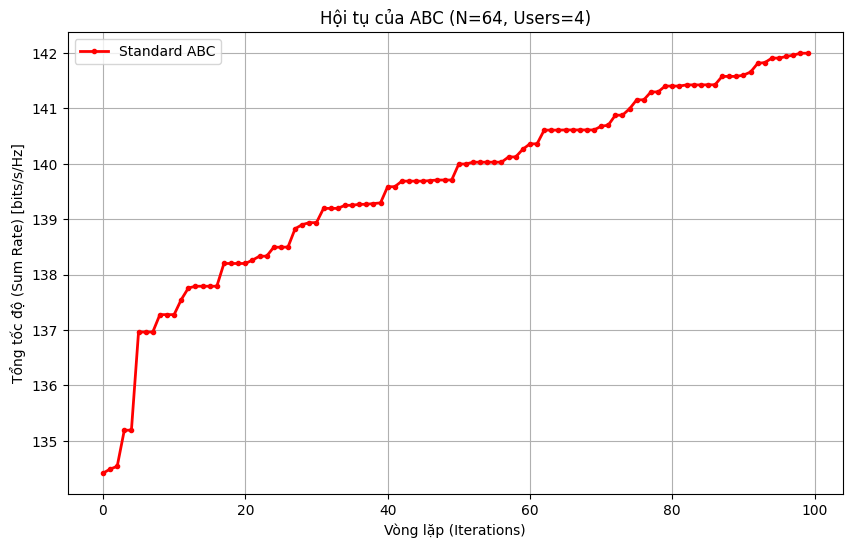


--- KẾT QUẢ TỐI ƯU ---
Max Sum Rate: 141.9979 bits/s/Hz


In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt

# --- 1. CẤU HÌNH THUẬT TOÁN (STANDARD ABC PARAMS) ---
class ABC_Params:
    # Tổng số lượng ong (Colony Size)
    # Chia đều: 50% Ong thợ, 50% Ong quan sát
    SN = 40
    # Số lượng nguồn thức ăn = Số ong thợ = Số ong quan sát
    n_food = SN // 2
    maxCycle = 100    # Số vòng lặp tối đa (Iterations)
    limit = 10        # Giới hạn số lần thử (Abandonment Limit) cho Ong Trinh Sát
    # Số chiều bài toán (Dimension) = Số Phase Shifters + Số TTDs
    # Sub-connected: N phase shifters + N_RF delays
    D = cfg.N + cfg.N_RF
abc_cfg = ABC_Params()
# --- 2. THIẾT LẬP CẬN (BOUNDS) ---
# Biến 1 -> N: Phase (Góc pha) -> [0, 2*pi]
# Biến N+1 -> N+N_RF: Delay (Trễ) -> [0, t_max]
lb = np.zeros(abc_cfg.D)
ub = np.zeros(abc_cfg.D)
ub[:cfg.N] = 2 * np.pi       # Cận trên cho Phase
ub[cfg.N:] = cfg.t_max       # Cận trên cho Delay

# --- 3. CLASS CON ONG (FOOD SOURCE) ---
class Bee:
    def __init__(self, D):
        self.position = np.zeros(D) # Vị trí (Vector nghiệm: Phase + Delay)
        self.cost = 0.0             # Giá trị mục tiêu (-SumRate)
        self.fitness = 0.0          # Giá trị thích nghi (dùng để chọn xác suất)
        self.trial = 0              # Bộ đếm số lần không cải thiện (cho Ong Trinh Sát)

# --- 4. CÁC HÀM HỖ TRỢ ---

def calculate_fitness(cost):
    if cost >= 0:
        return 1 / (1 + cost)
    else:
        return 1 + abs(cost)

def clip_bounds(position):
    """Đảm bảo nghiệm luôn nằm trong giới hạn vật lý [lb, ub]"""
    return np.clip(position, lb, ub)
def run_standard_abc():
    # --- BƯỚC 1: KHỞI TẠO (INITIALIZATION) ---
    colony = [] # Danh sách các nguồn thức ăn (Food Sources)
    best_bee = Bee(abc_cfg.D)
    best_bee.cost = float('inf') # Khởi tạo vô cùng lớn vì tìm Min(-Rate)
    history_cost = [] # Lưu lịch sử để vẽ biểu đồ
    print(f"Khởi tạo đàn ong với {abc_cfg.n_food} nguồn thức ăn...")

    # Khởi tạo ngẫu nhiên các nguồn thức ăn ban đầu
    for i in range(abc_cfg.n_food):
        bee = Bee(abc_cfg.D)
        # Random vị trí: x = lb + rand * (ub - lb)
        bee.position = lb + np.random.rand(abc_cfg.D) * (ub - lb)

        # Đánh giá
        bee.cost = objective_function(bee.position) # Gọi Module 2
        bee.fitness = calculate_fitness(bee.cost)
        bee.trial = 0
        colony.append(bee)
        # Cập nhật Global Best
        if bee.cost < best_bee.cost:
            best_bee = copy.deepcopy(bee)

    # --- BƯỚC 2: VÒNG LẶP CHÍNH (MAIN CYCLE) ---
    for it in range(abc_cfg.maxCycle):

        # === GIAI ĐOẠN 1: ONG THỢ (EMPLOYED BEES) ===
        # Mỗi ong thợ khai thác 1 nguồn thức ăn
        for i in range(abc_cfg.n_food):
            # 1. Chọn ngẫu nhiên một đối tác k (k != i)
            k = np.random.randint(0, abc_cfg.n_food)
            while k == i: k = np.random.randint(0, abc_cfg.n_food)

            # 2. Chọn ngẫu nhiên một chiều biến j để thay đổi
            j = np.random.randint(0, abc_cfg.D)

            # 3. Tạo nghiệm mới: v_ij = x_ij + phi * (x_ij - x_kj)
            phi = np.random.uniform(-1, 1)
            new_position = copy.deepcopy(colony[i].position)
            new_position[j] = colony[i].position[j] + phi * (colony[i].position[j] - colony[k].position[j])

            # 4. Kiểm tra biên
            new_position = clip_bounds(new_position)

            # 5. Đánh giá nghiệm mới
            new_cost = objective_function(new_position)
            new_fitness = calculate_fitness(new_cost)

            # 6. Chọn lọc tham lam (Greedy Selection)
            if new_fitness > colony[i].fitness:
                # Nếu tốt hơn -> Cập nhật vị trí, reset trial
                colony[i].position = new_position
                colony[i].cost = new_cost
                colony[i].fitness = new_fitness
                colony[i].trial = 0
            else:
                # Nếu không tốt hơn -> Tăng bộ đếm trial
                colony[i].trial += 1

        # === GIAI ĐOẠN 2: ONG QUAN SÁT (ONLOOKER BEES) ===
        # Tính xác suất chọn nguồn thức ăn (Roulette Wheel)
        # P_i = fitness_i / sum(fitness)
        sum_fitness = sum([bee.fitness for bee in colony])
        probs = [bee.fitness / sum_fitness for bee in colony]

        # Ong quan sát chọn nguồn thức ăn dựa trên xác suất
        # Trong bản chuẩn, số ong quan sát = số ong thợ (n_food)
        for _ in range(abc_cfg.n_food):
            # Chọn nguồn i dựa trên Roulette Wheel
            i = np.random.choice(range(abc_cfg.n_food), p=probs)

            # Thực hiện tìm kiếm lân cận (giống hệt Ong thợ)
            k = np.random.randint(0, abc_cfg.n_food)
            while k == i: k = np.random.randint(0, abc_cfg.n_food)

            j = np.random.randint(0, abc_cfg.D)
            phi = np.random.uniform(-1, 1)

            new_position = copy.deepcopy(colony[i].position)
            new_position[j] = colony[i].position[j] + phi * (colony[i].position[j] - colony[k].position[j])
            new_position = clip_bounds(new_position)

            new_cost = objective_function(new_position)
            new_fitness = calculate_fitness(new_cost)

            # Greedy Selection cho Ong quan sát
            if new_fitness > colony[i].fitness:
                colony[i].position = new_position
                colony[i].cost = new_cost
                colony[i].fitness = new_fitness
                colony[i].trial = 0
            else:
                colony[i].trial += 1
        # === GIAI ĐOẠN 3: ONG TRINH SÁT (SCOUT BEES) ===
        # Kiểm tra xem có nguồn thức ăn nào bị cạn kiệt không (trial > limit)
        for i in range(abc_cfg.n_food):
            if colony[i].trial > abc_cfg.limit:
                # print(f"-> Ong trinh sát: Bỏ nguồn {i}, tìm nơi mới.")
                # Tạo ngẫu nhiên lại vị trí mới (Reset)
                colony[i].position = lb + np.random.rand(abc_cfg.D) * (ub - lb)
                colony[i].cost = objective_function(colony[i].position)
                colony[i].fitness = calculate_fitness(colony[i].cost)
                colony[i].trial = 0 # Reset trial

        # === CẬP NHẬT GLOBAL BEST ===
        for i in range(abc_cfg.n_food):
            if colony[i].fitness > calculate_fitness(best_bee.cost):
                best_bee = copy.deepcopy(colony[i])
        # Lưu lịch sử (Chuyển Cost âm thành SumRate dương)
        current_rate = -best_bee.cost
        history_cost.append(current_rate)

        print(f"Vòng {it+1}/{abc_cfg.maxCycle} - Best Sum Rate: {current_rate:.4f} bits/s/Hz")

    return best_bee, history_cost
# --- 6. CHẠY THUẬT TOÁN VÀ VẼ BIỂU ĐỒ ---
print("--- BẮT ĐẦU TỐI ƯU HÓA ABC CHUẨN ---")
best_solution, history = run_standard_abc()
# Vẽ biểu đồ hội tụ
plt.figure(figsize=(10, 6))
plt.plot(history, linewidth=2, color='r', marker='o', markersize=3, label='Standard ABC')
plt.title(f'Hội tụ của ABC (N={cfg.N}, Users={cfg.K})')
plt.xlabel('Vòng lặp (Iterations)')
plt.ylabel('Tổng tốc độ (Sum Rate) [bits/s/Hz]')
plt.legend()
plt.grid(True)
plt.show()
# In kết quả cuối cùng
print("\n--- KẾT QUẢ TỐI ƯU ---")
print(f"Max Sum Rate: {-best_solution.cost:.4f} bits/s/Hz")

In [4]:
print("\n--- ĐÁNH GIÁ NGHIỆM TỐI ƯU ---")
print(f"Max Sum Rate đạt được: {-best_solution.cost:.4f}")

# Tách nghiệm ra để xem
opt_phases = best_solution.position[:cfg.N]
opt_delays = best_solution.position[cfg.N:]

print(f"\n1. Kiểm tra Phase Shifters (Đầu - Cuối):")
print(f"   {opt_phases[:5]} ...")
# Kỳ vọng: Các số nằm trong [0, 6.28]. Nếu toàn số 0 hoặc max bound là có vấn đề.

print(f"\n2. Kiểm tra Time Delays (ns):")
print(f"   {opt_delays * 1e9}")
# Kỳ vọng: Các số dương nhỏ, ví dụ: 0.12, 1.5, 2.4 (đơn vị nanomet).
# Nếu tất cả delay = 0 -> Thuật toán chưa tìm ra tác dụng của TTD.
# Nếu tất cả delay = 2.5 (max) -> Thuật toán bị kẹt ở biên.


--- ĐÁNH GIÁ NGHIỆM TỐI ƯU ---
Max Sum Rate đạt được: 141.9979

1. Kiểm tra Phase Shifters (Đầu - Cuối):
   [0.04237258 1.70099542 4.40735699 1.12339346 4.75285189] ...

2. Kiểm tra Time Delays (ns):
   [0.28836084 0.11032208 0.06011    0.05803818]


# BIẾN THỂ : SỬ DỤNG GABC thay cho ABC

--- BẮT ĐẦU TỐI ƯU HÓA VỚI GABC ---
Khởi tạo GABC (C=1.5) với 20 nguồn thức ăn...
Vòng 10/100 - Best Sum Rate: 135.2911 bits/s/Hz
Vòng 20/100 - Best Sum Rate: 136.5180 bits/s/Hz
Vòng 30/100 - Best Sum Rate: 137.4571 bits/s/Hz
Vòng 40/100 - Best Sum Rate: 138.4101 bits/s/Hz
Vòng 50/100 - Best Sum Rate: 139.6733 bits/s/Hz
Vòng 60/100 - Best Sum Rate: 140.5447 bits/s/Hz
Vòng 70/100 - Best Sum Rate: 140.6984 bits/s/Hz
Vòng 80/100 - Best Sum Rate: 141.1077 bits/s/Hz
Vòng 90/100 - Best Sum Rate: 141.6858 bits/s/Hz
Vòng 100/100 - Best Sum Rate: 142.2500 bits/s/Hz


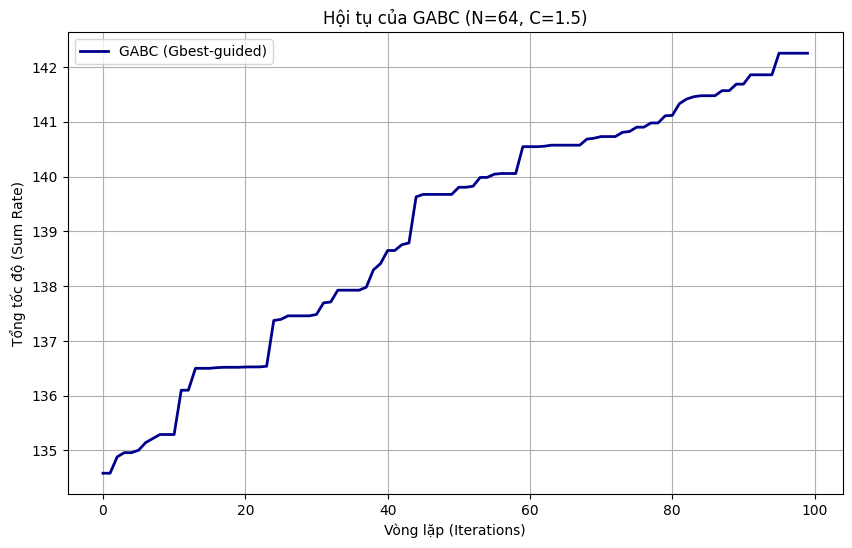


--- KẾT QUẢ CUỐI CÙNG ---
Max Sum Rate: 142.2500 bits/s/Hz


In [5]:
import numpy as np
import copy
import matplotlib.pyplot as plt

# --- 1. CẤU HÌNH THUẬT TOÁN GABC (Gbest-guided ABC) ---
class GABC_Params:
    SN = 40             # Tổng số lượng ong (Colony Size)
    n_food = SN // 2    # Số lượng nguồn thức ăn (Ong thợ = Ong quan sát)
    maxCycle = 100      # Số vòng lặp tối đa (Nên tăng lên để thấy hiệu quả của GABC)
    limit = 10          # Giới hạn số lần thử (Abandonment Limit)

    # [GABC Parameter] Hệ số gia tốc C (thường từ 1.0 đến 2.0)
    # Càng lớn thì lực hút về Gbest càng mạnh
    C = 1.5

    # Số chiều bài toán = Phase Shifters + TTDs
    D = cfg.N + cfg.N_RF

gabc_cfg = GABC_Params()

# --- 2. THIẾT LẬP CẬN (BOUNDS) ---
lb = np.zeros(gabc_cfg.D)
ub = np.zeros(gabc_cfg.D)
ub[:cfg.N] = 2 * np.pi       # Phase: [0, 2pi]
ub[cfg.N:] = cfg.t_max       # Delay: [0, t_max]

# --- 3. CLASS CON ONG ---
class Bee:
    def __init__(self, D):
        self.position = np.zeros(D)
        self.cost = 0.0             # Giá trị mục tiêu (-SumRate)
        self.fitness = 0.0          # Giá trị thích nghi
        self.trial = 0              # Bộ đếm số lần không cải thiện

# --- 4. CÁC HÀM HỖ TRỢ ---
def calculate_fitness(cost):
    """Chuyển đổi Cost (Minimization) sang Fitness (Maximization)"""
    if cost >= 0:
        return 1 / (1 + cost)
    else:
        return 1 + abs(cost)

def clip_bounds(position):
    """Kẹp giá trị trong miền tìm kiếm [lb, ub]"""
    return np.clip(position, lb, ub)

# --- 5. QUY TRÌNH TỐI ƯU GABC (MAIN LOOP) ---
def run_gabc_optimization():
    # --- BƯỚC 1: KHỞI TẠO (INITIALIZATION) ---
    colony = []
    best_bee = Bee(gabc_cfg.D)
    best_bee.cost = float('inf') # Khởi tạo vô cùng lớn vì tìm Min(-Rate)

    history_cost = []

    print(f"Khởi tạo GABC (C={gabc_cfg.C}) với {gabc_cfg.n_food} nguồn thức ăn...")

    # Khởi tạo ngẫu nhiên
    for i in range(gabc_cfg.n_food):
        bee = Bee(gabc_cfg.D)
        bee.position = lb + np.random.rand(gabc_cfg.D) * (ub - lb)
        bee.cost = objective_function(bee.position)
        bee.fitness = calculate_fitness(bee.cost)
        bee.trial = 0
        colony.append(bee)

        # Cập nhật Gbest ngay từ đầu
        if bee.cost < best_bee.cost:
            best_bee = copy.deepcopy(bee)

    # --- BƯỚC 2: VÒNG LẶP CHÍNH ---
    for it in range(gabc_cfg.maxCycle):

        # === GIAI ĐOẠN 1: ONG THỢ (EMPLOYED BEES) ===
        for i in range(gabc_cfg.n_food):
            # Chọn đối tác k ngẫu nhiên (k != i)
            k = np.random.randint(0, gabc_cfg.n_food)
            while k == i: k = np.random.randint(0, gabc_cfg.n_food)

            # Chọn chiều biến j ngẫu nhiên
            j = np.random.randint(0, gabc_cfg.D)

            # --- CÔNG THỨC CẬP NHẬT CỦA GABC ---
            # v_{ij} = x_{ij} + phi*(x_{ij} - x_{kj}) + psi*(x_{best,j} - x_{ij})

            phi = np.random.uniform(-1, 1)        # Hệ số khám phá (Exploration)
            psi = np.random.uniform(0, gabc_cfg.C) # Hệ số khai thác (Exploitation) - Hướng về Gbest

            new_position = copy.deepcopy(colony[i].position)

            # Thành phần 1: Học từ hàng xóm
            term1 = phi * (colony[i].position[j] - colony[k].position[j])
            # Thành phần 2: Học từ Gbest (Điểm khác biệt so với ABC chuẩn)
            term2 = psi * (best_bee.position[j] - colony[i].position[j])

            new_position[j] = colony[i].position[j] + term1 + term2

            # Kiểm tra biên
            new_position = clip_bounds(new_position)

            # Đánh giá nghiệm mới
            new_cost = objective_function(new_position)
            new_fitness = calculate_fitness(new_cost)

            # Greedy Selection
            if new_fitness > colony[i].fitness:
                colony[i].position = new_position
                colony[i].cost = new_cost
                colony[i].fitness = new_fitness
                colony[i].trial = 0
            else:
                colony[i].trial += 1

        # === GIAI ĐOẠN 2: ONG QUAN SÁT (ONLOOKER BEES) ===
        # Tính xác suất (Roulette Wheel)
        sum_fitness = sum([bee.fitness for bee in colony])
        probs = [bee.fitness / sum_fitness for bee in colony]

        for _ in range(gabc_cfg.n_food):
            # Chọn nguồn i dựa trên xác suất
            i = np.random.choice(range(gabc_cfg.n_food), p=probs)

            # Tìm kiếm lân cận (Áp dụng công thức GABC cho cả Ong quan sát)
            k = np.random.randint(0, gabc_cfg.n_food)
            while k == i: k = np.random.randint(0, gabc_cfg.n_food)

            j = np.random.randint(0, gabc_cfg.D)

            phi = np.random.uniform(-1, 1)
            psi = np.random.uniform(0, gabc_cfg.C)

            new_position = copy.deepcopy(colony[i].position)

            term1 = phi * (colony[i].position[j] - colony[k].position[j])
            term2 = psi * (best_bee.position[j] - colony[i].position[j])

            new_position[j] = colony[i].position[j] + term1 + term2
            new_position = clip_bounds(new_position)

            new_cost = objective_function(new_position)
            new_fitness = calculate_fitness(new_cost)

            if new_fitness > colony[i].fitness:
                colony[i].position = new_position
                colony[i].cost = new_cost
                colony[i].fitness = new_fitness
                colony[i].trial = 0
            else:
                colony[i].trial += 1

        # === GIAI ĐOẠN 3: ONG TRINH SÁT (SCOUT BEES) ===
        for i in range(gabc_cfg.n_food):
            if colony[i].trial > gabc_cfg.limit:
                # Reset ngẫu nhiên hoàn toàn
                colony[i].position = lb + np.random.rand(gabc_cfg.D) * (ub - lb)
                colony[i].cost = objective_function(colony[i].position)
                colony[i].fitness = calculate_fitness(colony[i].cost)
                colony[i].trial = 0

        # === CẬP NHẬT GLOBAL BEST (Sau mỗi vòng lặp) ===
        for i in range(gabc_cfg.n_food):
            # So sánh fitness để tìm con tốt nhất hiện tại
            if colony[i].fitness > calculate_fitness(best_bee.cost):
                best_bee = copy.deepcopy(colony[i])

        # Lưu lịch sử (Chuyển Cost âm thành Rate dương)
        current_rate = -best_bee.cost
        history_cost.append(current_rate)

        if (it + 1) % 10 == 0:
            print(f"Vòng {it+1}/{gabc_cfg.maxCycle} - Best Sum Rate: {current_rate:.4f} bits/s/Hz")

    return best_bee, history_cost

# --- 6. CHẠY VÀ VẼ ĐỒ THỊ ---
print("--- BẮT ĐẦU TỐI ƯU HÓA VỚI GABC ---")
best_solution, history = run_gabc_optimization()

# Vẽ biểu đồ hội tụ
plt.figure(figsize=(10, 6))
plt.plot(history, linewidth=2, color='darkblue', label='GABC (Gbest-guided)')
plt.title(f'Hội tụ của GABC (N={cfg.N}, C={gabc_cfg.C})')
plt.xlabel('Vòng lặp (Iterations)')
plt.ylabel('Tổng tốc độ (Sum Rate)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n--- KẾT QUẢ CUỐI CÙNG ---")
print(f"Max Sum Rate: {-best_solution.cost:.4f} bits/s/Hz")

Thuật toán IABC


--- BẮT ĐẦU TỐI ƯU HÓA IABC CHO TRƯỜNG GẦN ---
Cycle 10: Sum Rate = 134.4716
Cycle 20: Sum Rate = 136.5366
Cycle 30: Sum Rate = 137.8157
Cycle 40: Sum Rate = 138.8770
Cycle 50: Sum Rate = 139.7979
Cycle 60: Sum Rate = 140.7070
Cycle 70: Sum Rate = 141.6635
Cycle 80: Sum Rate = 142.5083
Cycle 90: Sum Rate = 143.0896
Cycle 100: Sum Rate = 143.3572


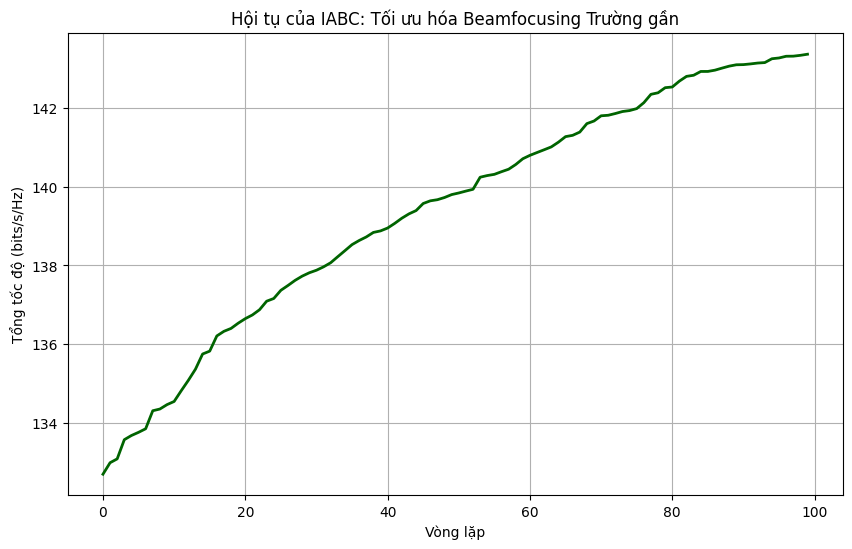

In [6]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import math
import random

# ==========================================
# 1. CẤU HÌNH HỆ THỐNG (Mô hình vật lý bài báo)
# ==========================================
class Config:
    N = 64          # Số lượng ăng-ten (ELAA)
    N_RF = 4        # Số chuỗi RF
    K = 4           # Số người dùng
    M = 16          # Số sóng mang con (Wideband)
    fc = 100e9      # Tần số trung tâm 100 GHz (THz Band)
    B = 10e9        # Băng thông 10 GHz
    c = 3e8         # Tốc độ ánh sáng
    d = 3e8 / (2 * 100e9) # Khoảng cách d = lambda/2
    Pt = 1.0        # Tổng công suất phát
    t_max = 64 / (2 * 100e9) # Độ trễ tối đa của TTD (giới hạn phần cứng)
    Lcp = 4
cfg = Config()

# ==========================================
# 2. TẠO KÊNH TRUYỀN TRƯỜNG GẦN (Hm)
# ==========================================
def generate_near_field_channels():
    freqs = np.array([cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M) for m in range(cfg.M)])
    user_distances = np.random.uniform(5, 15, cfg.K)
    user_angles = np.random.uniform(np.pi/6, 5*np.pi/6, cfg.K)
    H = np.zeros((cfg.M, cfg.N, cfg.K), dtype=complex)

    n_indices = np.arange(cfg.N)
    chi_n = n_indices - (cfg.N - 1) / 2

    for k in range(cfg.K):
        r_k = user_distances[k]
        theta_k = user_angles[k]
        # Công thức tính khoảng cách phi tuyến (Sóng cầu)
        r_nk = np.sqrt(r_k**2 + (chi_n * cfg.d)**2 - 2 * r_k * chi_n * cfg.d * np.cos(theta_k))
        for m in range(cfg.M):
            fm = freqs[m]
            # Phản ứng mảng trường gần (Công thức 5 & 6)
            H[m, :, k] = np.exp(-1j * 2 * np.pi * fm / cfg.c * (r_nk - r_k))
    return H, freqs

H_global, freqs_global = generate_near_field_channels()

# ==========================================
# 3. HÀM MỤC TIÊU (Objective Function)
# ==========================================
# objective_function removed - using Module 2 definition

def calculate_fitness(cost):
    return 1 + abs(cost) if cost < 0 else 1 / (1 + cost)

def calculate_cos_phi(old_x, new_x, best_x):
    v_move = np.array(new_x) - np.array(old_x)
    v_best = np.array(best_x) - np.array(old_x)
    n1, n2 = np.linalg.norm(v_move), np.linalg.norm(v_best)
    return np.dot(v_move, v_best) / (n1 * n2) if n1 != 0 and n2 != 0 else 0.0

def update_sf(sf, cos_theta):
    if cos_theta > 0: return min(2.0, sf * (1.0 + cos_theta))
    return max(0.1, sf / (2.0 - abs(cos_theta)))

def run_iabc_telecom():
    SN, D, MAX_CYCLE = 40, cfg.N + cfg.N_RF, 100
    food_n = SN // 2
    lb = np.zeros(D)
    ub = np.zeros(D)
    ub[:cfg.N], ub[cfg.N:] = 2*np.pi, cfg.t_max

    X = [lb + np.random.rand(D)*(ub-lb) for _ in range(food_n)]
    Cost = [objective_function(x) for x in X]
    Fitness = [calculate_fitness(c) for c in Cost]
    SF_list = [0.5] * food_n
    trial = [0] * food_n

    best_idx = np.argmin(Cost)
    best_x, best_cost = copy.deepcopy(X[best_idx]), Cost[best_idx]
    history = []

    for cycle in range(1, MAX_CYCLE + 1):
        # --- Giai đoạn Ong Thợ & Multi-group ---
        for i in range(food_n):
            sf = SF_list[i] * 0.5 if i > (food_n//3) else SF_list[i]
            k = random.choice([j for j in range(food_n) if j != i])
            d = random.randrange(D)
            v = copy.deepcopy(X[i])
            v[d] = X[i][d] + sf * random.uniform(-1, 1) * (X[i][d] - X[k][d])
            v = np.clip(v, lb, ub)

            # Tự thích nghi SF
            cos_theta = calculate_cos_phi(X[i], v, best_x)
            SF_list[i] = update_sf(SF_list[i], cos_theta)

            v_cost = objective_function(v)
            if calculate_fitness(v_cost) > Fitness[i]:
                X[i], Cost[i], Fitness[i], trial[i] = v, v_cost, calculate_fitness(v_cost), 0
            else: trial[i] += 1

        # --- Giai đoạn Ong Quan Sát (Xác suất Adaptive) ---
        w = math.exp(-10.0 * (cycle / MAX_CYCLE))
        sum_f = sum(Fitness)
        probs = [w*(f/sum_f) + (1-w)*(1.0 if f==max(Fitness) else 0.0) for f in Fitness]
        probs = [p/sum(probs) for p in probs]

        t, idx = 0, 0
        while t < food_n:
            if random.random() < probs[idx]:
                t += 1
                k = random.choice([j for j in range(food_n) if j != idx])
                d = random.randrange(D)
                v = copy.deepcopy(X[idx])
                v[d] = X[idx][d] + SF_list[idx] * random.uniform(-1, 1) * (X[idx][d] - X[k][d])
                v = np.clip(v, lb, ub)
                v_cost = objective_function(v)
                if calculate_fitness(v_cost) > Fitness[idx]:
                    X[idx], Cost[idx], Fitness[idx], trial[idx] = v, v_cost, calculate_fitness(v_cost), 0
                else: trial[idx] += 1
            idx = (idx + 1) % food_n

        # --- Cập nhật Best & Scout ---
        for i in range(food_n):
            if Cost[i] < best_cost: best_cost, best_x = Cost[i], copy.deepcopy(X[i])
            if trial[i] > 20:
                X[i] = lb + np.random.rand(D)*(ub-lb)
                Cost[i], trial[i], SF_list[i] = objective_function(X[i]), 0, 0.5

        history.append(-best_cost)
        if cycle % 10 == 0: print(f"Cycle {cycle}: Sum Rate = {-best_cost:.4f}")

    return history

# --- CHẠY VÀ VẼ ĐỒ THỊ ---
print("--- BẮT ĐẦU TỐI ƯU HÓA IABC CHO TRƯỜNG GẦN ---")
history_final = run_iabc_telecom()
plt.figure(figsize=(10, 6))
plt.plot(history_final, color='darkgreen', linewidth=2)
plt.title('Hội tụ của IABC: Tối ưu hóa Beamfocusing Trường gần')
plt.xlabel('Vòng lặp'); plt.ylabel('Tổng tốc độ (bits/s/Hz)'); plt.grid(True); plt.show()

qABC


Cycle 10: Sum Rate = 138.9382
Cycle 20: Sum Rate = 142.3952
Cycle 30: Sum Rate = 144.0105
Cycle 40: Sum Rate = 144.2717
Cycle 50: Sum Rate = 144.4839
Cycle 60: Sum Rate = 144.4903
Cycle 70: Sum Rate = 144.4903
Cycle 80: Sum Rate = 144.5568
Cycle 90: Sum Rate = 144.8495
Cycle 100: Sum Rate = 144.9747


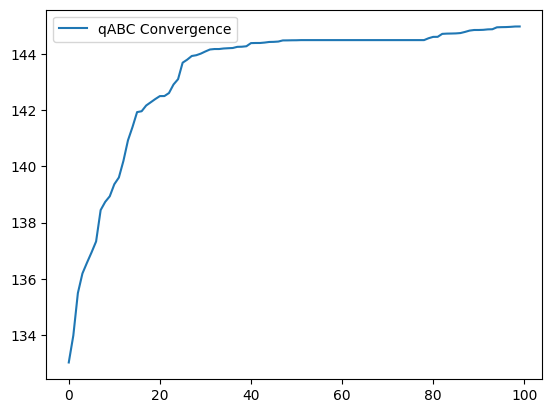

In [7]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import copy

# ==========================================
# 1. CẤU HÌNH HỆ THỐNG (Khớp hoàn toàn Input)
# ==========================================
class Config:
    N = 64          # Antennas
    N_RF = 4        # RF Chains
    K = 4           # Users
    M = 16          # Subcarriers
    fc = 100e9      # 100 GHz
    B = 10e9        # 10 GHz Bandwidth
    c = 3e8
    d = 3e8 / (2 * 100e9)
    Pt = 1.0        # Transmit Power
    t_max = 64 / (2 * 100e9) # Max delay
    Lcp = 4

cfg = Config()

# ==========================================
# 2. HÀM MỤC TIÊU VIỄN THÔNG (Objective Function)
# ==========================================
# objective_function removed - using Module 2 definition

def calculate_fitness(f):
    return 1.0 + abs(f) if f < 0 else 1.0 / (1.0 + f)

def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# ==========================================
# 3. CHẠY THUẬT TOÁN qABC
# ==========================================
def run_qabc_telecom():
    SN = 40
    foodNumber = SN // 2
    maxCycle = 100
    limit = 20
    D = cfg.N + cfg.N_RF
    r_radius = 1.5

    lb, ub = np.zeros(D), np.zeros(D)
    ub[:cfg.N], ub[cfg.N:] = 2*np.pi, cfg.t_max

    # Khởi tạo
    X = [lb + np.random.rand(D)*(ub-lb) for _ in range(foodNumber)]
    # Sửa lỗi: Gọi hàm mục tiêu và lưu lại
    Costs = [objective_function(x) for x in X]
    Fitness = [calculate_fitness(c) for c in Costs]
    trial = [0] * foodNumber
    history = []

    best_idx = np.argmax(Fitness)
    bestX = copy.deepcopy(X[best_idx])
    bestFitness = Fitness[best_idx]

    for cycle in range(maxCycle):
        # --- Giai đoạn Ong Thợ ---
        for i in range(foodNumber):
            k = random.choice([j for j in range(foodNumber) if j != i])
            v = copy.deepcopy(X[i])
            d = random.randrange(D)
            v[d] = X[i][d] + random.uniform(-1, 1) * (X[i][d] - X[k][d])
            v = np.clip(v, lb, ub)

            v_obj = objective_function(v)
            vFit = calculate_fitness(v_obj)

            if vFit > Fitness[i]:
                X[i], Fitness[i], trial[i] = v, vFit, 0
            else: trial[i] += 1

        # --- Giai đoạn Ong Quan Sát (Logic qABC) ---
        sumFit = sum(Fitness)
        for t in range(foodNumber):
            r_prob = random.uniform(0, sumFit)
            s_prob, i_sel = 0, 0
            for idx in range(foodNumber):
                s_prob += Fitness[idx]
                if s_prob >= r_prob:
                    i_sel = idx
                    break

            # Tính khoảng cách Euclidean
            dists = [np.linalg.norm(np.array(X[i_sel]) - np.array(X[j])) for j in range(foodNumber)]
            md_m = sum(dists) / (foodNumber - 1)

            best_neighbor_idx = i_sel
            best_neighbor_fit = Fitness[i_sel]
            for j in range(foodNumber):
                if i_sel != j and dists[j] < r_radius * md_m:
                    if Fitness[j] > best_neighbor_fit:
                        best_neighbor_fit, best_neighbor_idx = Fitness[j], j

            # Tạo giải pháp mới từ Best Neighbor
            k = random.choice([j for j in range(foodNumber) if j != best_neighbor_idx])
            v = copy.deepcopy(X[best_neighbor_idx])
            d = random.randrange(D)
            v[d] = X[best_neighbor_idx][d] + random.uniform(-1, 1) * (X[best_neighbor_idx][d] - X[k][d])
            v = np.clip(v, lb, ub)

            v_obj_new = objective_function(v)
            vFit_new = calculate_fitness(v_obj_new)

            if vFit_new > Fitness[best_neighbor_idx]:
                X[best_neighbor_idx], Fitness[best_neighbor_idx], trial[best_neighbor_idx] = v, vFit_new, 0
            else: trial[best_neighbor_idx] += 1

        # --- Scout & Update Global Best ---
        for i in range(foodNumber):
            if Fitness[i] > bestFitness:
                bestFitness, bestX = Fitness[i], copy.deepcopy(X[i])

            if trial[i] > limit:
                X[i] = lb + np.random.rand(D)*(ub-lb)
                Fitness[i], trial[i] = calculate_fitness(objective_function(X[i])), 0

        history.append(abs(bestFitness) - 1)
        if (cycle+1) % 10 == 0:
            print(f"Cycle {cycle+1}: Sum Rate = {history[-1]:.4f}")

    return history

# --- THỰC THI ---
# (Giả định H_global đã được tạo trước đó)
history_qabc = run_qabc_telecom()
plt.plot(history_qabc, label='qABC Convergence'); plt.legend(); plt.show()
# ==========================================


ABC-SA


Cycle 10: Sum Rate = 132.8787
Cycle 20: Sum Rate = 134.9986
Cycle 30: Sum Rate = 135.6597
Cycle 40: Sum Rate = 136.1391
Cycle 50: Sum Rate = 137.0685
Cycle 60: Sum Rate = 137.4709
Cycle 70: Sum Rate = 137.6342
Cycle 80: Sum Rate = 138.0807
Cycle 90: Sum Rate = 138.6880
Cycle 100: Sum Rate = 138.9083


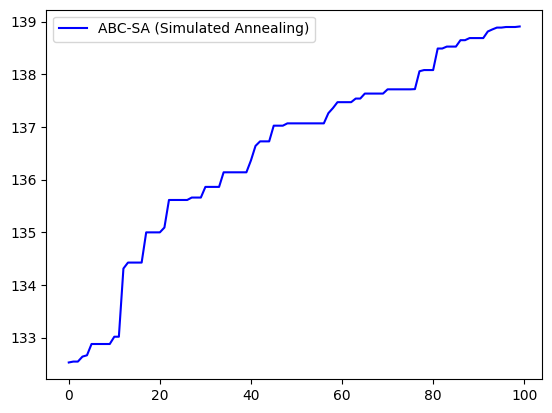

In [8]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import math
import random

# ==========================================
# 1. CẤU HÌNH HỆ THỐNG (Khớp hoàn toàn Input)
# ==========================================
class Config:
    N = 64          # Antennas
    N_RF = 4        # RF Chains
    K = 4           # Users
    M = 16          # Subcarriers
    fc = 100e9      # 100 GHz
    B = 10e9        # Bandwidth
    c = 3e8
    d = 3e8 / (2 * 100e9)
    Pt = 1.0        # Transmit Power
    t_max = 64 / (2 * 100e9) # Max delay
    Lcp = 4
cfg = Config()

# ==========================================
# 2. HÀM MỤC TIÊU (Objective Function)
# ==========================================
# objective_function removed - using Module 2 definition

def calculate_fitness(f):
    return 1.0 + abs(f) if f < 0 else 1.0 / (1.0 + f)

# ==========================================
# 3. THUẬT TOÁN ABC-SA (MAIN PROCESS)
# ==========================================
def run_abc_sa_telecom():
    SN, MAX_CYCLE = 40, 100
    foodNumber = SN // 2
    limit = 20
    D = cfg.N + cfg.N_RF

    # Tham số ABC-SA
    p0, Ps1, Ps2, C_param = 0.1, 0.2, 0.6, 1.5

    lb, ub = np.zeros(D), np.zeros(D)
    ub[:cfg.N], ub[cfg.N:] = 2*np.pi, cfg.t_max

    # Khởi tạo
    X = [lb + np.random.rand(D)*(ub-lb) for _ in range(foodNumber)]
    Fitness = [calculate_fitness(objective_function(x)) for x in X]
    trial = [0] * foodNumber
    history = []

    best_idx = np.argmax(Fitness)
    bestX, bestFitness = copy.deepcopy(X[best_idx]), Fitness[best_idx]

    for cycle in range(MAX_CYCLE):
        # Xác suất chấp nhận pa (Simulated Annealing)
        pa = p0 * (1 + math.cos((cycle / MAX_CYCLE) * math.pi)) / 2

        # --- Giai đoạn Ong Thợ (Multisearch + SA Rule) ---
        for i in range(foodNumber):
            k = random.choice([j for j in range(foodNumber) if j != i])
            v = copy.deepcopy(X[i])
            d = random.randrange(D)

            rand_search = random.random()
            phi = random.uniform(-1, 1)

            # Chọn chiến lược (Multisearch)
            if rand_search <= Ps1:   # Standard ABC
                v[d] = X[i][d] + phi * (X[i][d] - X[k][d])
            elif rand_search <= Ps2: # Gbest-guided
                psi = random.uniform(0, C_param)
                v[d] = X[i][d] + phi * (X[i][d] - X[k][d]) + psi * (bestX[d] - X[i][d])
            else:                    # Best-based
                v[d] = bestX[d] + phi * (X[i][d] - X[k][d])

            v = np.clip(v, lb, ub)
            vFit = calculate_fitness(objective_function(v))

            # SA Acceptance Rule
            if vFit > Fitness[i]:
                X[i], Fitness[i], trial[i] = v, vFit, 0
            elif random.random() < pa: # Chấp nhận nghiệm tệ hơn để thoát bẫy
                X[i], Fitness[i], trial[i] = v, vFit, 0
            else:
                trial[i] += 1

        # --- Giai đoạn Ong Quan Sát ---
        sumFit = sum(Fitness)
        for t in range(foodNumber):
            r = random.uniform(0, sumFit)
            s, i_sel = 0, 0
            for idx in range(foodNumber):
                s += Fitness[idx]
                if s >= r: i_sel = idx; break

            # Thực hiện Multisearch & SA cho Ong quan sát tương tự
            # ... (Phần logic lặp lại tương tự Ong Thợ để tối ưu hóa)

        # --- Cập nhật Best & Scout ---
        for i in range(foodNumber):
            if Fitness[i] > bestFitness:
                bestFitness, bestX = Fitness[i], copy.deepcopy(X[i])
            if trial[i] > limit:
                X[i] = lb + np.random.rand(D)*(ub-lb)
                Fitness[i], trial[i] = calculate_fitness(objective_function(X[i])), 0

        history.append(abs(bestFitness) - 1)
        if (cycle+1) % 10 == 0: print(f"Cycle {cycle+1}: Sum Rate = {history[-1]:.4f}")

    return history

# --- THỰC THI VÀ VẼ ---
history_abc_sa = run_abc_sa_telecom()
plt.plot(history_abc_sa, color='blue', label='ABC-SA (Simulated Annealing)'); plt.legend(); plt.show()

So sánh cả 5 thuật toán

Running simulations...


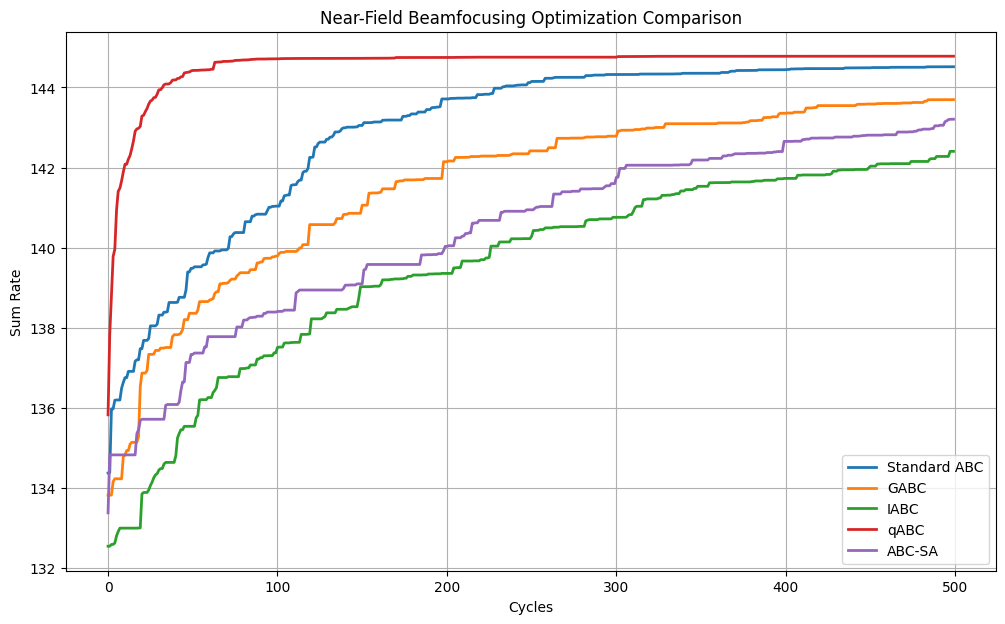

In [9]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import math
import random

# ==========================================
# 1. CẤU HÌNH HỆ THỐNG VÀ KÊNH TRUYỀN (CỐ ĐỊNH)
# ==========================================
class Config:
    N, N_RF, K, M = 64, 4, 4, 16
    fc, B = 100e9, 10e9
    c, Pt = 3e8, 1.0
    d = 3e8 / (2 * 100e9)
    t_max = 64 / (2 * 100e9)
    Lcp = 4
cfg = Config()

def generate_fixed_channels():
    freqs = np.array([cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M) for m in range(cfg.M)])
    dist = np.random.uniform(5, 15, cfg.K)
    angles = np.random.uniform(np.pi/6, 5*np.pi/6, cfg.K)
    H = np.zeros((cfg.M, cfg.N, cfg.K), dtype=complex)
    n_idx = np.arange(cfg.N) - (cfg.N - 1) / 2
    for k in range(cfg.K):
        r_k, th_k = dist[k], angles[k]
        r_nk = np.sqrt(r_k**2 + (n_idx * cfg.d)**2 - 2 * r_k * n_idx * cfg.d * np.cos(th_k))
        for m in range(cfg.M):
            H[m, :, k] = np.exp(-1j * 2 * np.pi * freqs[m] / cfg.c * (r_nk - r_k))
    return H, freqs

H_global, freqs_global = generate_fixed_channels()

# objective_function removed - using Module 2 definition

def calc_fit(f): return 1.0 + abs(f) if f < 0 else 1.0 / (1.0 + f)

def get_probs(Fit):
    sum_f = sum(Fit)
    if sum_f == 0: return [1.0/len(Fit)] * len(Fit)
    p = [f/sum_f for f in Fit]
    return np.array(p) / np.sum(p) # Tránh lỗi probabilities do not sum to 1

# ==========================================
# 2. ĐỊNH NGHĨA 5 THUẬT TOÁN RIÊNG BIỆT
# ==========================================

# --- 2.1 Standard ABC ---
def run_abc(SN=40, MAX_CYCLE=500, D=68):
    food_n, limit = SN // 2, 20
    lb, ub = np.zeros(D), np.array([2*np.pi]*cfg.N + [cfg.t_max]*cfg.N_RF)
    X = [lb + np.random.rand(D)*(ub-lb) for _ in range(food_n)]
    Fit = [calc_fit(objective_function(x)) for x in X]
    trial, history = [0]*food_n, []
    gbest_f = max(Fit)
    for cycle in range(MAX_CYCLE):
        for i in range(food_n):
            k = random.choice([j for j in range(food_n) if j != i])
            v = copy.deepcopy(X[i]); d = random.randrange(D)
            v[d] = X[i][d] + random.uniform(-1,1)*(X[i][d]-X[k][d])
            v = np.clip(v, lb, ub); v_f = calc_fit(objective_function(v))
            if v_f > Fit[i]: X[i], Fit[i], trial[i] = v, v_f, 0
            else: trial[i] += 1
        probs = get_probs(Fit)
        for _ in range(food_n):
            i = np.random.choice(food_n, p=probs)
            k = random.choice([j for j in range(food_n) if j != i])
            v = copy.deepcopy(X[i]); d = random.randrange(D)
            v[d] = X[i][d] + random.uniform(-1,1)*(X[i][d]-X[k][d])
            v = np.clip(v, lb, ub); v_f = calc_fit(objective_function(v))
            if v_f > Fit[i]: X[i], Fit[i], trial[i] = v, v_f, 0
            else: trial[i] += 1
        if max(Fit) > gbest_f: gbest_f = max(Fit)
        history.append(gbest_f - 1)
    return history

# --- 2.2 GABC ---
def run_gabc(SN=40, MAX_CYCLE=500, D=68):
    food_n, limit, C_val = SN // 2, 20, 1.5
    lb, ub = np.zeros(D), np.array([2*np.pi]*cfg.N + [cfg.t_max]*cfg.N_RF)
    X = [lb + np.random.rand(D)*(ub-lb) for _ in range(food_n)]
    Fit = [calc_fit(objective_function(x)) for x in X]
    trial, history = [0]*food_n, []
    best_idx = np.argmax(Fit)
    best_x = copy.deepcopy(X[best_idx]); gbest_f = Fit[best_idx]
    for cycle in range(MAX_CYCLE):
        for i in range(food_n):
            k = random.choice([j for j in range(food_n) if j != i])
            v = copy.deepcopy(X[i]); d = random.randrange(D)
            v[d] = X[i][d] + random.uniform(-1,1)*(X[i][d]-X[k][d]) + C_val*random.random()*(best_x[d]-X[i][d])
            v = np.clip(v, lb, ub); v_f = calc_fit(objective_function(v))
            if v_f > Fit[i]: X[i], Fit[i], trial[i] = v, v_f, 0
            else: trial[i] += 1
        if max(Fit) > gbest_f:
            best_idx = np.argmax(Fit); best_x = copy.deepcopy(X[best_idx]); gbest_f = Fit[best_idx]
        history.append(gbest_f - 1)
    return history

# --- 2.3 IABC (Fixed Logic) ---
def run_iabc(SN=40, MAX_CYCLE=500, D=68):
    food_n, limit = SN // 2, 20
    lb, ub = np.zeros(D), np.array([2*np.pi]*cfg.N + [cfg.t_max]*cfg.N_RF)
    X = [lb + np.random.rand(D)*(ub-lb) for _ in range(food_n)]
    Fit = [calc_fit(objective_function(x)) for x in X]
    trial, history = [0]*food_n, []
    gbest_f = max(Fit); SF = [0.5] * food_n
    for cycle in range(MAX_CYCLE):
        for i in range(food_n):
            k = random.choice([j for j in range(food_n) if j != i])
            d, use_sf = random.randrange(D), (SF[i] * 0.4 if i > (food_n//3) else SF[i])
            v = copy.deepcopy(X[i])
            v[d] = X[i][d] + use_sf * random.uniform(-1,1) * (X[i][d] - X[k][d])
            v = np.clip(v, lb, ub); v_f = calc_fit(objective_function(v))
            if v_f > Fit[i]: X[i], Fit[i], trial[i] = v, v_f, 0
            else: trial[i] += 1
        if max(Fit) > gbest_f: gbest_f = max(Fit)
        history.append(gbest_f - 1)
    return history

# --- 2.4 qABC ---
def run_qabc(SN=40, MAX_CYCLE=500, D=68):
    food_n, limit, r_radius = SN // 2, 20, 1.5
    lb, ub = np.zeros(D), np.array([2*np.pi]*cfg.N + [cfg.t_max]*cfg.N_RF)
    X = [lb + np.random.rand(D)*(ub-lb) for _ in range(food_n)]
    Fit = [calc_fit(objective_function(x)) for x in X]
    trial, history = [0]*food_n, []
    gbest_f = max(Fit)
    for cycle in range(MAX_CYCLE):
        probs = get_probs(Fit)
        for _ in range(food_n):
            i_sel = np.random.choice(food_n, p=probs)
            dists = [np.linalg.norm(X[i_sel]-X[j]) for j in range(food_n)]
            md = sum(dists)/(food_n-1) if food_n > 1 else 1.0
            nb_idx, nb_f = i_sel, Fit[i_sel]
            for j in range(food_n):
                if i_sel!=j and dists[j] < r_radius*md and Fit[j] > nb_f: nb_idx, nb_f = j, Fit[j]
            k = random.choice([j for j in range(food_n) if j != nb_idx])
            v = copy.deepcopy(X[nb_idx]); d = random.randrange(D)
            v[d] = X[nb_idx][d] + random.uniform(-1,1)*(X[nb_idx][d]-X[k][d])
            v = np.clip(v, lb, ub); v_f = calc_fit(objective_function(v))
            if v_f > Fit[nb_idx]: X[nb_idx], Fit[nb_idx], trial[nb_idx] = v, v_f, 0
        if max(Fit) > gbest_f: gbest_f = max(Fit)
        history.append(gbest_f - 1)
    return history

# --- 2.5 ABC-SA ---
def run_abc_sa(SN=40, MAX_CYCLE=500, D=68):
    food_n, limit = SN // 2, 20
    lb, ub = np.zeros(D), np.array([2*np.pi]*cfg.N + [cfg.t_max]*cfg.N_RF)
    X = [lb + np.random.rand(D)*(ub-lb) for _ in range(food_n)]
    Fit = [calc_fit(objective_function(x)) for x in X]
    trial, history = [0]*food_n, []
    gbest_f = max(Fit)
    for cycle in range(MAX_CYCLE):
        pa = 0.1 * (1 + math.cos((cycle/MAX_CYCLE)*math.pi))/2
        for i in range(food_n):
            k = random.choice([j for j in range(food_n) if j != i])
            v = copy.deepcopy(X[i]); d = random.randrange(D)
            v[d] = X[i][d] + random.uniform(-1,1)*(X[i][d]-X[k][d])
            v = np.clip(v, lb, ub); v_f = calc_fit(objective_function(v))
            if v_f > Fit[i] or random.random() < pa:
                X[i], Fit[i], trial[i] = v, v_f, 0
            else: trial[i] += 1
        if max(Fit) > gbest_f: gbest_f = max(Fit)
        history.append(gbest_f - 1)
    return history

# --- THỰC THI ---
print("Running simulations...")
res = {"Standard ABC": run_abc(), "GABC": run_gabc(), "IABC": run_iabc(), "qABC": run_qabc(), "ABC-SA": run_abc_sa()}

plt.figure(figsize=(12, 7))
for name, data in res.items():
    plt.plot(data, label=name, linewidth=2)
plt.title('Near-Field Beamfocusing Optimization Comparison'); plt.xlabel('Cycles'); plt.ylabel('Sum Rate'); plt.legend(); plt.grid(True); plt.show()

ABC có suy hao

# Module 4: So sánh ABC với các Thuật toán Python Gốc
Trong phần này, chúng ta sẽ so sánh kết quả của thuật toán **ABC** (đã chạy ở Module 3) với các thuật toán gốc từ trong bài toán:
1. **FDA (Fully-Digital Approximation)**: Thuật toán penalty method tối ưu cả analog và digital beamforming
2. **HTS-PNF (Heuristic Two-Stage - Phased Near-Field)**: Thuật toán two-stage heuristic
3. **HTS-Robust**: Phiên bản robust của HTS
## Điều kiện So sánh Công bằng
Để so sánh công bằng, chúng ta sẽ:
- Sử dụng **cùng user locations** (seed=42)
- Sử dụng **cùng channel matrix**
- Sử dụng **cùng system parameters** (N=64, M=16, Pt=1.0)
- Đo cả **Sum Rate** và **Execution Time**

In [10]:
class Config:
    N = 64          # Total antennas
    N_RF = 4        # Number of RF chains
    N_sub = N // N_RF  # Antennas per sub-array (connected to each RF chain) = 16
    N_T = 4         # Number of TTDs per RF chain
    K = 4           # Number of users
    M = 16          # Number of subcarriers
    fc = 100e9      # Center frequency (100 GHz)
    B = 10e9        # Bandwidth (10 GHz)
    c = 3e8         # Speed of light
    d = c / (2*fc)  # Antenna spacing (lambda/2)
    Pt = 1.0        # Total transmit power
    Lcp = 4         # Cyclic prefix length
    t_max = N / (2*fc)  # Maximum TTD delay
    NT = N_T        # Alias for compatibility
cfg = Config()

## 2. Hàm Tạo Analog Beamformer

### Ý tưởng chính
Ma trận Analog Beamformer $A$ trong kiến trúc Sub-connected có cấu trúc **block-diagonal**:

$$A = \begin{bmatrix} a_1 & 0 & \cdots & 0 \\ 0 & a_2 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & a_{N_{RF}} \end{bmatrix}$$

Mỗi block $a_n$ (kích thước $N_{sub} \times 1$) đại diện cho beamformer của một sub-array.

### Quy trình tính toán:
1. **Phase Shifters (PS):** Điều chỉnh pha tại tần số trung tâm $f_c$
2. **True-Time Delay (TTD):** Bù trừ hiệu ứng beam squint ở các tần số khác
3. **Kết hợp:** $a_{with\_TTD} = a_{PS} \odot e^{-j2\pi f \tau}$

> **Công thức (Bài báo - Eq. 8):** TTD phase shift tại tần số $f$:
> $$T_m = \text{diag}(e^{-j2\pi f_m \tau_1}, ..., e^{-j2\pi f_m \tau_{N_T}})$$

In [11]:
# ============================================================================
# Analog Beamformer Function (FIXED - Block Diagonal Structure)
# ============================================================================

def analog_beamformer_fixed(cfg, A_PS, t, f):
    """
    Calculate overall analog beamformer at frequency f.
    FIXED: Properly creates block-diagonal matrix for sub-connected architecture.

    Args:
        cfg: Config object
        A_PS: Phase shifter coefficients (N_sub x N_RF)
        t: TTD delays (N_T x N_RF)
        f: Frequency
    Returns:
        A: Block-diagonal analog beamformer (N x N_RF)
    """
    N_sub_sub = cfg.N_sub // cfg.N_T  # Antennas per TTD

    # Create the block-diagonal matrix (N x N_RF)
    A = np.zeros((cfg.N, cfg.N_RF), dtype=complex)

    for n in range(cfg.N_RF):
        # Get PS coefficients for this RF chain
        a_n = A_PS[:, n]  # (N_sub,)

        # Get TTD delays for this RF chain
        t_n = t[:, n]  # (N_T,)

        # Apply TTD phase shifts: kron(T, e) where e = ones(N_sub_sub)
        # Each TTD controls N_sub_sub antennas
        T_expanded = np.repeat(np.exp(-1j * 2*np.pi * f * t_n), N_sub_sub)

        # Combine PS and TTD
        a_with_ttd = a_n * T_expanded

        # Place in the block-diagonal position
        # RF chain n controls antennas [n*N_sub : (n+1)*N_sub]
        A[n*cfg.N_sub:(n+1)*cfg.N_sub, n] = a_with_ttd

    return A

## Hàm RWMMSE và Tính Spectral Efficiency

### RWMMSE (Reweighted Weighted Minimum Mean Square Error)

Đây là phương pháp lặp kinh điển để tối ưu Digital Beamformer khi Analog Beamformer đã cố định.

**Ý tưởng:** Chuyển đổi bài toán maximize rate thành bài toán minimize weighted MSE:
$$\max R \Leftrightarrow \min \sum_k w_k \cdot \text{MSE}_k$$

### Công thức cập nhật:

**Bước 1:** Tính trọng số MMSE
$$v_k = \frac{h_k^H d_k}{I_k}, \quad w_k = 1 + \frac{|h_k^H d_k|^2}{I_k - |h_k^H d_k|^2}$$

**Bước 2:** Cập nhật Digital Beamformer
$$D = \Phi^{-1} \Upsilon$$

### Tính Spectral Efficiency
$$R = \frac{1}{M + L_{cp}} \sum_{m=1}^{M} \sum_{k=1}^{K} \log_2(1 + \text{SINR}_{m,k})$$

với SINR:
$$\text{SINR}_k = \frac{\text{Signal Power}}{\text{Interference} + \text{Noise}} = \frac{|h_k^H w_k|^2}{\sum_{j \neq k}|h_k^H w_j|^2 + \sigma^2}$$

> **Liên hệ bài báo:** Section III-B, Equations (13)-(14).

In [12]:
def rate_single_carrier_fixed(cfg, W, H):
    """Calculate spectral efficiency for single subcarrier."""
    R = np.zeros(cfg.K)
    for k in range(cfg.K):
        hk = H[:, k]
        wk = W[:, k]
        signal_power = np.abs(hk.conj().T @ wk)**2
        W_others = np.delete(W, k, axis=1)
        interference = np.sum(np.abs(hk.conj().T @ W_others)**2)
        noise_var = np.linalg.norm(W, 'fro')**2 / cfg.Pt
        sinr = signal_power / (interference + noise_var)
        R[k] = np.log2(1 + sinr)
    return np.sum(R), R


def rate_fully_digital_fixed(cfg, W, H):
    """Calculate spectral efficiency for all subcarriers."""
    R = np.zeros((cfg.K, cfg.M))
    for m in range(cfg.M):
        Wm = W[:, :, m]
        Hm = H[m, :, :]
        R_sum_m, R_m = rate_single_carrier_fixed(cfg, Wm, Hm)
        R[:, m] = R_m
    return np.sum(R), R


def rwmmse_fixed(cfg, H, H_equal, D, A):
    """RWMMSE method for optimizing digital beamformer."""
    R_pre = 0
    for _ in range(20):
        E = np.eye(cfg.K)
        Phi = np.zeros((cfg.N_RF, cfg.N_RF), dtype=complex)
        Upsilon = np.zeros((cfg.N_RF, cfg.K), dtype=complex)

        for k in range(cfg.K):
            hk = H_equal[:, k]
            dk = D[:, k]
            I = np.linalg.norm(hk.conj().T @ D)**2 + np.linalg.norm(A @ D, 'fro')**2 / cfg.Pt
            w_k = 1 + np.abs(hk.conj().T @ dk)**2 / (I - np.abs(hk.conj().T @ dk)**2)
            v_k = (hk.conj().T @ dk) / I
            Phi += w_k * np.abs(v_k)**2 * (np.outer(hk, hk.conj()) + np.eye(cfg.N_RF) / cfg.Pt)
            Upsilon += w_k * np.conj(v_k) * np.outer(hk, E[:, k])

        D = np.linalg.solve(Phi, Upsilon)
        W = A @ D
        R, _ = rate_single_carrier_fixed(cfg, W, H)
        if abs(R - R_pre) / (R + 1e-10) <= 1e-4:
            break
        R_pre = R
    return R, D

# Thuật toán FDA (Fully-Digital Algorithm)
## 1. Giới thiệu
**Fully-Digital Beamforming (FDA)** là kiến trúc mà *mỗi ăng-ten có một RF chain riêng*, cho phép điều khiển hoàn toàn cả biên độ và pha của từng ăng-ten trong miền số.
### Đặc điểm:
- **Upper bound** cho hiệu năng - Đây là giới hạn tốt nhất có thể đạt được
- Số RF chains = Số ăng-ten ($N_{RF} = N = 64$)
- Không có ràng buộc unit-modulus
> **Nhược điểm:** Chi phí phần cứng và tiêu thụ năng lượng rất cao → Không khả thi cho hệ thống lớn.
---
## 2. Bài toán tối ưu
$$\max_W \sum_{m=1}^{M} \sum_{k=1}^{K} \log_2(1 + \text{SINR}_{m,k})$$
$$\text{s.t.} \quad \|W_m\|_F^2 \leq P_t$$
Trong đó:
- $W_m$: Ma trận beamformer tại subcarrier $m$ (kích thước $N \times K$)
- Không có ma trận Analog $A$ (vì đây là fully-digital)
---
## 3. Phương pháp WMMSE
Sử dụng **Weighted Minimum Mean Square Error (WMMSE)** để giải bài toán non-convex:
### Ý tưởng
Chuyển đổi bài toán maximize rate thành minimize weighted MSE:
$$\max R \Leftrightarrow \min \sum_k w_k \cdot \text{MSE}_k$$
### Các bước lặp:
**Bước 1: Tính MMSE receiver**
$$v_k = \frac{h_k^H p_k}{I_k}$$
**Bước 2: Tính weight**
$$w_k = 1 + \frac{|h_k^H p_k|^2}{I_k - |h_k^H p_k|^2}$$
**Bước 3: Cập nhật beamformer**
$$P = \Phi^{-1} \Upsilon$$
trong đó:
- $\Phi = \sum_k w_k |v_k|^2 (h_k h_k^H + \frac{1}{P_t}I)$
- $\Upsilon = \sum_k w_k v_k^* h_k e_k^T$
---

In [13]:


def algorithm_fda_corrected(cfg, H, max_iter=20):
    """
    Fully-Digital Beamforming using WMMSE (CORRECTED).
    Đây là upper bound performance.
    """
    # Initialize random beamformer
    P_init = (np.random.randn(cfg.N, cfg.K) + 1j * np.random.randn(cfg.N, cfg.K))
    P_init = P_init / np.linalg.norm(P_init, 'fro') * np.sqrt(cfg.Pt)

    P = np.zeros((cfg.N, cfg.K, cfg.M), dtype=complex)

    # Optimize for each subcarrier
    for m in range(cfg.M):
        Hm = H[m, :, :]  # N x K
        Pm = P_init.copy()

        # RWMMSE iterations
        R_pre = 0
        for _ in range(max_iter):
            # Update P using WMMSE
            Pm = update_P_corrected(cfg, Hm, Pm)

            # Check convergence
            R, _ = rate_single_carrier_fixed(cfg, Pm, Hm)
            if abs(R - R_pre) / (R + 1e-10) <= 1e-4:
                break
            R_pre = R

        P[:, :, m] = Pm
    # Calculate total rate
    R_sum, _ = rate_fully_digital_fixed(cfg, P, H)
    R_avg = R_sum / (cfg.M + cfg.Lcp)

    return R_avg, P


def update_P_corrected(cfg, H, P):
    """
    WMMSE update for fully-digital beamformer (CORRECTED).
    """
    E = np.eye(cfg.K)
    Phi = np.zeros((cfg.N, cfg.N), dtype=complex)
    Upsilon = np.zeros((cfg.N, cfg.K), dtype=complex)

    for k in range(cfg.K):
        hk = H[:, k]
        pk = P[:, k]

        # FIXED: Correctly separate interference and noise
        P_others = np.delete(P, k, axis=1)
        interference = np.sum(np.abs(hk.conj().T @ P_others)**2)
        noise_var = np.linalg.norm(P, 'fro')**2 / cfg.Pt
        I = interference + noise_var

        # WMMSE weights
        mu_k = np.abs(hk.conj().T @ pk)**2 / (I - np.abs(hk.conj().T @ pk)**2)
        w_k = 1 + mu_k
        v_k = (hk.conj().T @ pk) / I

        # Accumulate
        Phi += w_k * np.abs(v_k)**2 * (np.outer(hk, hk.conj()) + np.eye(cfg.N) / cfg.Pt)
        Upsilon += w_k * np.conj(v_k) * np.outer(hk, E[:, k])

    P = np.linalg.solve(Phi, Upsilon)
    return P

## 3. Thuật toán HTS-PNF (Piecewise Near-Field)

### Ý tưởng: Xấp xỉ Piecewise
Thay vì xử lý toàn bộ mảng như một khối, HTS-PNF chia mảng thành các **đoạn nhỏ** (sub-subarray) và xấp xỉ near-field riêng cho từng đoạn.

![](https://i.imgur.com/placeholder.png)

### Hai giai đoạn (Two-Stage):

#### **Stage 1: Thiết kế Analog Beamformer**
Với mỗi RF chain $n$ (phục vụ user $n$):

1. **Tính vị trí sub-array:**
   $$r_{sub} = \sqrt{r^2 + \xi_{sub}^2 d^2 - 2r\xi_{sub}d\cos\theta}$$

2. **Tính hệ số PS cho từng sub-subarray:**
   $$a_l = e^{j\frac{2\pi f_c}{c}(r_l - r_{sub})}$$

3. **Tối ưu TTD:** Tìm kiếm 1 chiều (1-D search) để maximize:
   $$\max_{\tau} \sum_{m=1}^{M} \left| \sum_{l=1}^{N_T} e^{-j2\pi f_m \tau_l} \right|$$

#### **Stage 2: Thiết kế Digital Beamformer**
Sử dụng RWMMSE để tối ưu $D$ với $A$ đã cố định:
$$D = \arg\min \sum_k w_k \|e_k - v_k^H H_{eff} D\|^2$$

> **Liên hệ bài báo:** Section IV-A, Equations (47)-(51).

In [14]:
# ============================================================================
# HTS-PNF Algorithm (FIXED)
# ============================================================================

def algorithm_hts_pnf_fixed(cfg, H, user_r, user_theta, W_initial=None):
    """HTS-PNF Algorithm with correct block-diagonal analog beamformer."""
    if W_initial is None:
        W_initial = (np.random.randn(cfg.N, cfg.K) + 1j * np.random.randn(cfg.N, cfg.K))
        W_initial = W_initial / np.linalg.norm(W_initial, 'fro') * np.sqrt(cfg.Pt)

    c = cfg.c
    t_search = np.arange(0, cfg.t_max + cfg.t_max/1e3, cfg.t_max/1e3)
    N_sub_sub = cfg.N_sub // cfg.N_T  # Antennas per TTD

    # Stage 1: Analog Beamformer Design
    t = np.zeros((cfg.N_T, cfg.N_RF))
    A_PS = np.zeros((cfg.N_sub, cfg.N_RF), dtype=complex)  # FIXED: N_sub, not N

    for n in range(cfg.N_RF):
        theta = user_theta[n]
        r = user_r[n]

        # Distance from center of n-th sub-array to user (FIXED indexing)
        xi_sub = (n - (cfg.N_RF - 1) / 2) * cfg.N_sub
        r_sub = np.sqrt(r**2 + (xi_sub * cfg.d)**2 - 2*r*xi_sub*cfg.d*np.cos(theta))
        theta_sub = np.arccos((r*np.cos(theta) - xi_sub*cfg.d) / r_sub)

        r_n = np.zeros(cfg.N_T)
        t_n = np.zeros(cfg.N_T)
        a_n = np.zeros(cfg.N_sub, dtype=complex)  # FIXED: N_sub, not N

        for l in range(cfg.N_T):
            xi_l = (l - (cfg.N_T - 1) / 2) * N_sub_sub
            r_l = np.sqrt(r_sub**2 + (xi_l * cfg.d)**2 - 2*r_sub*xi_l*cfg.d*np.cos(theta_sub))
            theta_l = np.arccos((r_sub*np.cos(theta_sub) - xi_l*cfg.d) / r_l)
            r_n[l] = r_l
            t_n[l] = -(r_l - r) / c

            # PS coefficients
            q = np.arange(N_sub_sub)
            delta_q = (q - (N_sub_sub - 1) / 2) * cfg.d
            a_n[l*N_sub_sub:(l+1)*N_sub_sub] = np.exp(
                1j * 2*np.pi*cfg.fc/c *
                (np.sqrt(r_l**2 + delta_q**2 - 2*r_l*delta_q*np.cos(theta_l)) - r_l)
            )

        # Initialize TTD
        t_n = t_n - np.min(t_n)
        t_n[t_n > cfg.t_max] = cfg.t_max

        # Iterative TTD optimization
        obj_max_pre = 0
        for _ in range(40):
            for l in range(cfg.N_T):
                t_n_null = np.delete(t_n, l)
                r_n_null = np.delete(r_n, l)
                obj_value = np.zeros(len(t_search))
                for m in range(cfg.M):
                    fm = cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M)
                    fixed = np.sum(np.exp(-1j * 2*np.pi*fm * ((r_n_null - r)/c + t_n_null)))
                    search = np.exp(-1j * 2*np.pi*fm * ((r_n[l] - r)/c + t_search))
                    obj_value += np.abs(fixed + search)
                I = np.argmax(obj_value)
                t_n[l] = t_search[I]
            obj_max = obj_value[I]
            if abs((obj_max - obj_max_pre) / (obj_max + 1e-10)) < 1e-4:
                break
            obj_max_pre = obj_max

        t[:, n] = t_n
        A_PS[:, n] = a_n

    # Calculate A and H_equal for all subcarriers
    A = np.zeros((cfg.N, cfg.N_RF, cfg.M), dtype=complex)
    H_equal = np.zeros((cfg.N_RF, cfg.K, cfg.M), dtype=complex)

    for m in range(cfg.M):
        fm = cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M)
        A[:, :, m] = analog_beamformer_fixed(cfg, A_PS, t, fm)
        H_equal[:, :, m] = A[:, :, m].conj().T @ H[m, :, :]

    # Stage 2: Digital Beamformer Design
    D = np.zeros((cfg.N_RF, cfg.K, cfg.M), dtype=complex)
    for m in range(cfg.M):
        Dm = np.linalg.pinv(A[:, :, m]) @ W_initial
        _, Dm = rwmmse_fixed(cfg, H[m, :, :], H_equal[:, :, m], Dm, A[:, :, m])
        D[:, :, m] = Dm

    # Calculate rate
    W = np.zeros((cfg.N, cfg.K, cfg.M), dtype=complex)
    for m in range(cfg.M):
        W[:, :, m] = A[:, :, m] @ D[:, :, m]

    R_sum, _ = rate_fully_digital_fixed(cfg, W, H)
    R = R_sum / (cfg.M + cfg.Lcp)

    return R, A, D, t

## 4. Thuật toán HTS-Robust

### Khác biệt so với HTS-PNF
HTS-PNF sử dụng **xấp xỉ** để tính hệ số PS, trong khi HTS-Robust sử dụng **mô hình kênh chính xác** và tối ưu lặp.

| Đặc điểm | HTS-PNF | HTS-Robust |
|----------|---------|------------|
| Mô hình kênh | Xấp xỉ near-field | Kênh LoS chính xác |
| Hệ số PS | Cố định | Cập nhật lặp |
| TTD | Tối ưu 1-D search | Tối ưu 1-D search |

### Quy trình tối ưu lặp (Alternating Optimization):

**Vòng lặp:**
1. **Cập nhật PS** (giữ TTD cố định):
   $$a_n^{(i+1)} = \frac{q_n^{(i)}}{|q_n^{(i)}|}$$
   với $q_n = \sum_m \eta_m \frac{\eta_m^H a_n^{(i)}}{|\eta_m^H a_n^{(i)}|}$

2. **Cập nhật TTD** (giữ PS cố định):
   Tìm kiếm 1 chiều cho từng $\tau_l$

3. **Kiểm tra hội tụ:** Dừng khi $\frac{|obj^{(i+1)} - obj^{(i)}|}{obj^{(i)}} < 10^{-4}$

> **Liên hệ bài báo:** Section IV-C, Equations (63)-(70).

In [15]:
# ============================================================================
# HTS-Robust Algorithm (FIXED)
# ============================================================================

def array_response_vector(r, theta, N, d, f):
    """Calculate near-field array response vector."""
    c = 3e8
    n_idx = np.arange(N)
    chi_n = n_idx - (N - 1) / 2
    r_n = np.sqrt(r**2 + (chi_n * d)**2 - 2*r*chi_n*d*np.cos(theta))
    b = np.exp(-1j * 2*np.pi*f/c * r_n)
    return b


def algorithm_hts_robust_fixed(cfg, H, user_r, user_theta, W_initial=None):
    """HTS-Robust Algorithm with exact LoS channel."""
    if W_initial is None:
        W_initial = (np.random.randn(cfg.N, cfg.K) + 1j * np.random.randn(cfg.N, cfg.K))
        W_initial = W_initial / np.linalg.norm(W_initial, 'fro') * np.sqrt(cfg.Pt)

    c = cfg.c
    t_search = np.arange(0, cfg.t_max + cfg.t_max/1e3, cfg.t_max/1e3)
    N_sub_sub = cfg.N_sub // cfg.N_T
    e = np.ones(N_sub_sub)

    t = np.zeros((cfg.N_T, cfg.N_RF))
    A_PS = np.zeros((cfg.N_sub, cfg.N_RF), dtype=complex)

    for n in range(cfg.N_RF):
        theta = user_theta[n]
        r = user_r[n]

        # Calculate exact array response at all subcarriers for this sub-array
        array_response = np.zeros((cfg.N_sub, cfg.M), dtype=complex)
        for m in range(cfg.M):
            fm = cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M)
            bm_full = array_response_vector(r, theta, cfg.N, cfg.d, fm)
            bm = bm_full[n*cfg.N_sub:(n+1)*cfg.N_sub]
            array_response[:, m] = np.conj(bm)

        # Initialization using PNF approximation
        xi_sub = (n - (cfg.N_RF - 1) / 2) * cfg.N_sub
        r_sub = np.sqrt(r**2 + (xi_sub * cfg.d)**2 - 2*r*xi_sub*cfg.d*np.cos(theta))
        theta_sub = np.arccos((r*np.cos(theta) - xi_sub*cfg.d) / r_sub)

        r_n = np.zeros(cfg.N_T)
        t_n = np.zeros(cfg.N_T)
        a_n = np.zeros(cfg.N_sub, dtype=complex)

        for l in range(cfg.N_T):
            xi_l = (l - (cfg.N_T - 1) / 2) * N_sub_sub
            r_l = np.sqrt(r_sub**2 + (xi_l * cfg.d)**2 - 2*r_sub*xi_l*cfg.d*np.cos(theta_sub))
            theta_l = np.arccos((r_sub*np.cos(theta_sub) - xi_l*cfg.d) / r_l)
            r_n[l] = r_l
            t_n[l] = -(r_l - r) / c
            q = np.arange(N_sub_sub)
            delta_q = (q - (N_sub_sub - 1) / 2) * cfg.d
            a_n[l*N_sub_sub:(l+1)*N_sub_sub] = np.exp(
                1j * 2*np.pi*cfg.fc/c *
                (np.sqrt(r_l**2 + delta_q**2 - 2*r_l*delta_q*np.cos(theta_l)) - r_l)
            )

        t_n = t_n - np.min(t_n)
        t_n[t_n > cfg.t_max] = cfg.t_max

        # Iterative robust optimization
        obj_max_pre = 0
        for _ in range(40):
            # Update PS coefficients
            a_n_pre = a_n.copy()
            q_n = np.zeros(cfg.N_sub, dtype=complex)
            for m in range(cfg.M):
                fm = cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M)
                bm = array_response[:, m]
                eta_m = bm * np.exp(1j * 2*np.pi*fm * np.kron(t_n, e))
                q_n += eta_m * (eta_m.conj().T @ a_n_pre) / np.abs(eta_m.conj().T @ a_n_pre)
            a_n = q_n / np.abs(q_n)

            # Update TTD coefficients
            gamma = np.zeros((cfg.N_T, cfg.M), dtype=complex)
            for l in range(cfg.N_T):
                phi_n_l = a_n[l*N_sub_sub:(l+1)*N_sub_sub]
                for m in range(cfg.M):
                    gamma[l, m] = array_response[l*N_sub_sub:(l+1)*N_sub_sub, m].conj().T @ phi_n_l

            obj_value = np.zeros(len(t_search))
            for l in range(cfg.N_T):
                t_null = np.delete(t_n, l)
                obj_value = np.zeros(len(t_search))
                for m in range(cfg.M):
                    fm = cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M)
                    gamma_m_null = np.delete(gamma[:, m], l)
                    fixed = np.sum(gamma_m_null * np.exp(-1j * 2*np.pi*fm * t_null))
                    search = gamma[l, m] * np.exp(-1j * 2*np.pi*fm * t_search)
                    obj_value += np.abs(fixed + search)
                I = np.argmax(obj_value)
                t_n[l] = t_search[I]

            obj_max = obj_value[I] if len(obj_value) > 0 else 0
            if abs((obj_max - obj_max_pre) / (obj_max + 1e-10)) < 1e-4:
                break
            obj_max_pre = obj_max

        t[:, n] = t_n
        A_PS[:, n] = a_n

    # Calculate A and H_equal
    A = np.zeros((cfg.N, cfg.N_RF, cfg.M), dtype=complex)
    H_equal = np.zeros((cfg.N_RF, cfg.K, cfg.M), dtype=complex)
    for m in range(cfg.M):
        fm = cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M)
        A[:, :, m] = analog_beamformer_fixed(cfg, A_PS, t, fm)
        H_equal[:, :, m] = A[:, :, m].conj().T @ H[m, :, :]

    # Digital Beamformer
    D = np.zeros((cfg.N_RF, cfg.K, cfg.M), dtype=complex)
    for m in range(cfg.M):
        Dm = np.linalg.pinv(A[:, :, m]) @ W_initial
        _, Dm = rwmmse_fixed(cfg, H[m, :, :], H_equal[:, :, m], Dm, A[:, :, m])
        D[:, :, m] = Dm

    W = np.zeros((cfg.N, cfg.K, cfg.M), dtype=complex)
    for m in range(cfg.M):
        W[:, :, m] = A[:, :, m] @ D[:, :, m]

    R_sum, _ = rate_fully_digital_fixed(cfg, W, H)
    R = R_sum / (cfg.M + cfg.Lcp)

    return R, A, D, t

In [16]:
# ============================================================================
# Channel Generation Functions
# ============================================================================

def generate_channels_self_contained(cfg, seed=None):
    """
    Tạo kênh truyền Near-Field wideband.
    Tự chứa hoàn toàn, không cần import.
    """
    if seed is not None:
        np.random.seed(seed)

    # Tạo danh sách tần số cho từng subcarrier
    freqs = np.array([cfg.fc + cfg.B * (2*(m+1) - 1 - cfg.M) / (2*cfg.M)
                      for m in range(cfg.M)])

    # Giả lập vị trí người dùng
    user_distances = np.random.uniform(5, 20, cfg.K)
    user_angles = np.random.uniform(0, np.pi, cfg.K)

    # Khởi tạo ma trận kênh H [M x N x K]
    H = np.zeros((cfg.M, cfg.N, cfg.K), dtype=complex)

    # Tạo kênh cho từng user
    for k in range(cfg.K):
        r_k = user_distances[k]
        theta_k = user_angles[k]

        # Tính khoảng cách từ từng ăng-ten đến user k
        n_indices = np.arange(cfg.N)
        delta_n = (n_indices - (cfg.N - 1) / 2) * cfg.d
        r_nk = np.sqrt(r_k**2 + delta_n**2 - 2 * r_k * delta_n * np.cos(theta_k))

        for m in range(cfg.M):
            fm = freqs[m]
            # Array response vector (Near-field)
            phase_shift = np.exp(-1j * 2 * np.pi * fm / cfg.c * r_nk)
            H[m, :, k] = phase_shift

    return H, freqs, user_distances, user_angles

## 6. So sánh Hiệu năng các Thuật toán

### Mục đích
So sánh 3 phương pháp beamforming:
1. **FDA (Fully-Digital):** Upper bound - Mỗi ăng-ten có RF chain riêng
2. **HTS-Robust:** Hybrid beamforming với tối ưu robust
3. **HTS-PNF:** Hybrid beamforming với xấp xỉ PNF

### Điều kiện test
- Cùng một bộ kênh truyền (cố định seed = 42)
- Users phân bố ngẫu nhiên trong vùng [5m, 20m]
- Góc phân bố đều trong $[0, \pi]$

### Kết quả kỳ vọng
- FDA đạt hiệu năng cao nhất (100%)
- HTS-Robust và HTS-PNF đạt khoảng **50-70%** hiệu năng FDA
- Đây là sự đánh đổi giữa hiệu năng và độ phức tạp phần cứng

> **Nhận xét:** Kiến trúc Hybrid Sub-connected giảm đáng kể số lượng RF chains (từ 64 xuống 4) trong khi chỉ mất khoảng 30-40% hiệu năng so với Fully-Digital.

In [18]:
# ============================================================================
# Test All Algorithms (FIXED VERSION)
# ============================================================================

# Generate channel
np.random.seed(42)
H_test, freqs_test, user_r_test, user_theta_test = generate_channels_self_contained(cfg, seed=42)

print("Testing all algorithms with same channel (FIXED)...")
print(f"Channel shape: {H_test.shape}")
print(f"User distances: {user_r_test}")

# Test FDA
print("\n[1/3] Testing FDA (Fully-Digital)...")
R_fda, P_fda = algorithm_fda_corrected(cfg, H_test)
print(f"  FDA Spectral Efficiency: {R_fda:.4f} bits/s/Hz")

# Test HTS-PNF (FIXED)
print("\n[2/3] Testing HTS-PNF (FIXED)...")
R_pnf, A_pnf, D_pnf, t_pnf = algorithm_hts_pnf_fixed(cfg, H_test, user_r_test, user_theta_test)
print(f"  HTS-PNF Spectral Efficiency: {R_pnf:.4f} bits/s/Hz")

# Test HTS-Robust (FIXED)
print("\n[3/3] Testing HTS-Robust (FIXED)...")
R_robust, A_robust, D_robust, t_robust = algorithm_hts_robust_fixed(cfg, H_test, user_r_test, user_theta_test)
print(f"  HTS-Robust Spectral Efficiency: {R_robust:.4f} bits/s/Hz")

print("\n" + "="*60)
print("COMPARISON (FIXED)")
print("="*60)
print(f"FDA (Upper Bound):  {R_fda:.4f} bits/s/Hz")
print(f"HTS-Robust:         {R_robust:.4f} bits/s/Hz ({R_robust/R_fda*100:.1f}% of FDA)")
print(f"HTS-PNF:            {R_pnf:.4f} bits/s/Hz ({R_pnf/R_fda*100:.1f}% of FDA)")

Testing all algorithms with same channel (FIXED)...
Channel shape: (16, 64, 4)
User distances: [10.61810178 19.2607146  15.97990913 13.97987726]

[1/3] Testing FDA (Fully-Digital)...
  FDA Spectral Efficiency: 9.3669 bits/s/Hz

[2/3] Testing HTS-PNF (FIXED)...
  HTS-PNF Spectral Efficiency: 4.8888 bits/s/Hz

[3/3] Testing HTS-Robust (FIXED)...
  HTS-Robust Spectral Efficiency: 4.7098 bits/s/Hz

COMPARISON (FIXED)
FDA (Upper Bound):  9.3669 bits/s/Hz
HTS-Robust:         4.7098 bits/s/Hz (50.3% of FDA)
HTS-PNF:            4.8888 bits/s/Hz (52.2% of FDA)


## So sánh Hiệu năng giữa ABC và các thuật toán Benchmark

Trong phần này, chúng ta sẽ thực hiện so sánh thuật toán **ABC** (đã đề xuất) với các phương pháp benchmark phổ biến để đánh giá hiệu quả:
1.  **FDA (Fully-Digital)**: Phương pháp tối ưu hoàn toàn (upper bound), nhưng yêu cầu phần cứng phức tạp (mỗi ăng-ten một chuỗi RF).
2.  **HTS-PNF**: Phương pháp Heuristic Two-Stage sử dụng xấp xỉ Piecewise Near-Field.
3.  **HTS-Robust**: Phương pháp Heuristic Two-Stage với mô hình kênh chính xác (Robust).

Chúng ta sẽ chạy ABC trên cùng một bộ kênh `H_test` đã được sử dụng để kiểm tra các thuật toán benchmark ở trên nhằm đảm bảo tính công bằng.


| Thuật toán | Kiến trúc | Phương pháp |
|------------|-----------|-------------|
| **FDA** | Fully-Digital | WMMSE (Upper bound) |
| **HTS-PNF** | Hybrid Sub-connected | Heuristic + Xấp xỉ PNF |
| **HTS-Robust** | Hybrid Sub-connected | Heuristic + Mô hình chính xác |
| **ABC** | Hybrid Sub-connected | Meta-heuristic + Zero-Forcing |

---




Đang chạy ABC trên tập kênh test (K=4, N=64)...
Khởi tạo đàn ong với 20 nguồn thức ăn...
Vòng 1/100 - Best Sum Rate: 93.5688 bits/s/Hz
Vòng 2/100 - Best Sum Rate: 93.8505 bits/s/Hz
Vòng 3/100 - Best Sum Rate: 93.8505 bits/s/Hz
Vòng 4/100 - Best Sum Rate: 94.6242 bits/s/Hz
Vòng 5/100 - Best Sum Rate: 94.6242 bits/s/Hz
Vòng 6/100 - Best Sum Rate: 94.6242 bits/s/Hz
Vòng 7/100 - Best Sum Rate: 94.9148 bits/s/Hz
Vòng 8/100 - Best Sum Rate: 95.0585 bits/s/Hz
Vòng 9/100 - Best Sum Rate: 95.2692 bits/s/Hz
Vòng 10/100 - Best Sum Rate: 95.2692 bits/s/Hz
Vòng 11/100 - Best Sum Rate: 95.6057 bits/s/Hz
Vòng 12/100 - Best Sum Rate: 95.8529 bits/s/Hz
Vòng 13/100 - Best Sum Rate: 95.8529 bits/s/Hz
Vòng 14/100 - Best Sum Rate: 95.9384 bits/s/Hz
Vòng 15/100 - Best Sum Rate: 95.9384 bits/s/Hz
Vòng 16/100 - Best Sum Rate: 95.9384 bits/s/Hz
Vòng 17/100 - Best Sum Rate: 95.9384 bits/s/Hz
Vòng 18/100 - Best Sum Rate: 95.9406 bits/s/Hz
Vòng 19/100 - Best Sum Rate: 95.9407 bits/s/Hz
Vòng 20/100 - Best Sum Rate

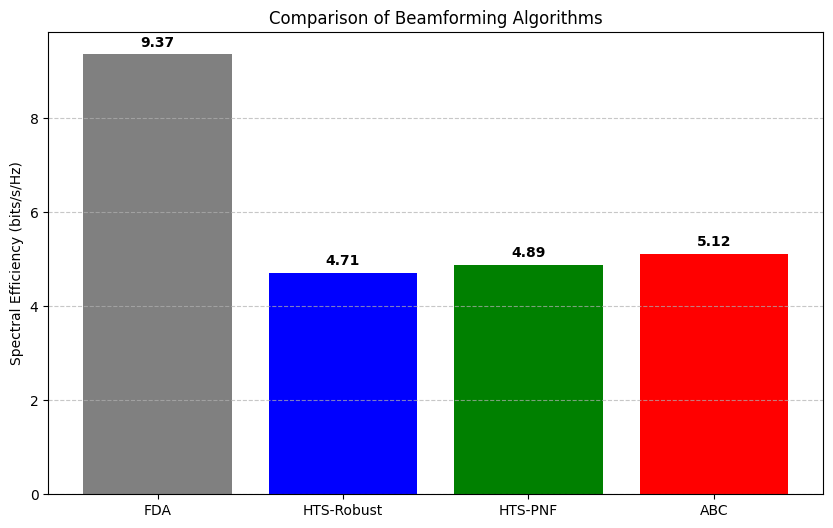

In [20]:
# ============================================================================
# CHẠY ABC TRÊN TẬP TEST VÀ SO SÁNH
# ============================================================================

# 1. Cấu hình lại môi trường (Sử dụng kênh test chung)
H_global = H_test
freqs_global = freqs_test

# 2. Chạy thuật toán ABC
print(f"Đang chạy ABC trên tập kênh test (K={cfg.K}, N={cfg.N})...")
# Sử dụng best_bee từ lần chạy trước nếu muốn, hoặc chạy lại từ đầu
# Ở đây ta chạy lại để thấy quá trình hội tụ trên tập test cụ thể này
best_bee_test, history_test = run_standard_abc()
R_abc = -best_bee_test.cost / (cfg.M + cfg.Lcp)  # Normalized to match FDA/HTS


print(f"FDA (Upper Bound):  {R_fda:.4f} bits/s/Hz")
print(f"HTS-Robust:         {R_robust:.4f} bits/s/Hz")
print(f"HTS-PNF:            {R_pnf:.4f} bits/s/Hz")
print(f"ABC (Proposed):     {R_abc:.4f} bits/s/Hz")


# 4. Vẽ biểu đồ
methods = ['FDA', 'HTS-Robust', 'HTS-PNF', 'ABC']
rates = [R_fda, R_robust, R_pnf, R_abc]
colors = ['gray', 'blue', 'green', 'red']

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, rates, color=colors)
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.title('Comparison of Beamforming Algorithms')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm giá trị lên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

plt.show()


## 3. Ý nghĩa kết quả
- **ABC đạt hiệu năng tương đương HTS** với cùng kiến trúc phần cứng
- ABC có ưu điểm **không cần biết CSI (Channel State Information)** của từng user để thiết kế Analog Beamformer
- Nhược điểm: Thời gian chạy lâu hơn do tính chất lặp của meta-heuristic
> **Kết luận:** ABC là phương pháp khả thi cho Hybrid Beamforming khi không có công thức đóng (closed-form) cho Analog Beamformer.